In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from internal.utils import temporal_split
from internal import run_eda_pipeline, run_preprocessing_pipeline, run_training_pipeline, run_inference_pipeline

2025-09-12 14:09:48,346	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-12 14:09:48,470	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-12 14:09:48,470	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# Cargar datos de Olist Forecasting
print("📊 CARGANDO DATOS DE OLIST FORECASTING")

# Cargar datasets de forecasting
olist_forecasting_dataset = pd.read_csv('olist_forecasting_dataset.csv')
olist_forecasting_test = pd.read_csv('olist_forecasting_test.csv')
olist_forecasting_train = pd.read_csv('olist_forecasting_train.csv')

print(f"📋 Forecasting Dataset: {olist_forecasting_dataset.shape}")
print(f"📋 Forecasting Test: {olist_forecasting_test.shape}")
print(f"📋 Forecasting Train: {olist_forecasting_train.shape}")

print(f"✅ Datos de forecasting cargados exitosamente")

# Mostrar primeras filas para revisar estructura
print("\n🔍 Estructura del dataset principal:")
print(olist_forecasting_dataset.head())
print(f"\nColumnas disponibles: {list(olist_forecasting_dataset.columns)}")

📊 CARGANDO DATOS DE OLIST FORECASTING
📋 Forecasting Dataset: (35415, 55)
📋 Forecasting Test: (4613, 55)
📋 Forecasting Train: (30802, 55)
✅ Datos de forecasting cargados exitosamente

🔍 Estructura del dataset principal:
                          seller_id year_week  pedidos  ingresos_total  \
0  0015a82c2db000af6aaaf3ae2ecb0532  2017-W39        1           895.0   
1  0015a82c2db000af6aaaf3ae2ecb0532  2017-W41        1           895.0   
2  0015a82c2db000af6aaaf3ae2ecb0532  2017-W42        1           895.0   
3  001cca7ae9ae17fb1caed9dfb1094831  2017-W05        1            99.9   
4  001cca7ae9ae17fb1caed9dfb1094831  2017-W07        5           499.5   

   precio_promedio  envio_total  envio_promedio  pago_total  pago_promedio  \
0            895.0        21.02           21.02      916.02         916.02   
1            895.0        21.02           21.02      916.02         916.02   
2            895.0        21.02           21.02      916.02         916.02   
3             99.9      

In [3]:
olist_forecasting_dataset

,seller_id,year_week,pedidos,ingresos_total,precio_promedio,envio_total,envio_promedio,pago_total,pago_promedio,clientes_unicos,...,antiguedad_dias,year_week_datetime,week_of_year,month,quarter,seller_state_encoded,seller_city_encoded,ingresos_per_pedido,clientes_per_pedido,items_per_pedido
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-W39,1,895.0,895.000,21.02,21.020,916.02,916.020,1,...,336.0,2017-09-25,39,9,3,21,470,895.000,1.0,1.0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-W41,1,895.0,895.000,21.02,21.020,916.02,916.020,1,...,336.0,2017-10-09,41,10,4,21,470,895.000,1.0,1.0
2,0015a82c2db000af6aaaf3ae2ecb0532,2017-W42,1,895.0,895.000,21.02,21.020,916.02,916.020,1,...,336.0,2017-10-16,42,10,4,21,470,895.000,1.0,1.0
3,001cca7ae9ae17fb1caed9dfb1094831,2017-W05,1,99.9,99.900,21.15,21.150,121.05,121.050,1,...,570.0,2017-01-30,5,1,1,4,116,99.900,1.0,1.0
4,001cca7ae9ae17fb1caed9dfb1094831,2017-W07,5,499.5,99.900,74.35,14.870,2869.25,573.850,1,...,570.0,2017-02-13,7,2,1,4,116,99.900,0.2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35410,fffd5413c0700ac820c7069d66d98c89,2018-W34,1,196.8,196.800,42.36,42.360,239.16,239.160,1,...,400.0,2018-08-27,35,8,3,21,8,196.800,1.0,1.0
35411,ffff564a4f9085cd26170f4732393726,2016-W40,1,51.5,51.500,14.53,14.530,66.03,66.030,1,...,690.0,2016-10-03,40,10,4,21,98,51.500,1.0,1.0
35412,ffff564a4f9085cd26170f4732393726,2016-W41,1,69.0,69.000,11.94,11.940,80.94,80.940,1,...,690.0,2016-10-10,41,10,4,21,98,69.000,1.0,1.0
35413,ffff564a4f9085cd26170f4732393726,2017-W03,4,179.5,44.875,51.31,12.828,230.81,57.702,4,...,690.0,2017-01-16,3,1,1,21,98,44.875,1.0,1.0


In [4]:
olist_forecasting_dataset.sort_values(by= ['seller_id', 'year_week_datetime'])[['seller_id', 'year_week_datetime']]

,seller_id,year_week_datetime
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-25
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-09
2,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-16
3,001cca7ae9ae17fb1caed9dfb1094831,2017-01-30
4,001cca7ae9ae17fb1caed9dfb1094831,2017-02-13
...,...,...
35410,fffd5413c0700ac820c7069d66d98c89,2018-08-27
35411,ffff564a4f9085cd26170f4732393726,2016-10-03
35412,ffff564a4f9085cd26170f4732393726,2016-10-10
35413,ffff564a4f9085cd26170f4732393726,2017-01-16


In [5]:
data = olist_forecasting_dataset
frequency = 'W-MON'

ids_col = 'seller_id'
date_col ='year_week_datetime'

label_col = 'pedidos'
HORIZON = 4

df = data[[ids_col, date_col, label_col]]

In [6]:
df[date_col] = pd.to_datetime(df[date_col])

In [7]:
df

,seller_id,year_week_datetime,pedidos
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-25,1
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-09,1
2,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-16,1
3,001cca7ae9ae17fb1caed9dfb1094831,2017-01-30,1
4,001cca7ae9ae17fb1caed9dfb1094831,2017-02-13,5
...,...,...,...
35410,fffd5413c0700ac820c7069d66d98c89,2018-08-27,1
35411,ffff564a4f9085cd26170f4732393726,2016-10-03,1
35412,ffff564a4f9085cd26170f4732393726,2016-10-10,1
35413,ffff564a4f9085cd26170f4732393726,2017-01-16,4


In [8]:
# Crear agregación mensual de pedidos por seller_id
df_monthly = df.copy()
df_monthly[date_col] = pd.to_datetime(df_monthly[date_col])
df_monthly['year_month'] = df_monthly[date_col].dt.to_period('M')

# Agrupar por seller_id y mes, sumando los pedidos
monthly_summary = df_monthly.groupby([ids_col, 'year_month'])[label_col].sum().reset_index()
monthly_summary['year_month'] = monthly_summary['year_month'].dt.to_timestamp()

# print(monthly_summary.groupby('year_month')[label_col].agg(['sum', 'mean', 'count']).round(2))

In [9]:
df = monthly_summary

In [10]:
df

,seller_id,year_month,pedidos
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-01,1
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-01,2
2,001cca7ae9ae17fb1caed9dfb1094831,2017-01-01,1
3,001cca7ae9ae17fb1caed9dfb1094831,2017-02-01,13
4,001cca7ae9ae17fb1caed9dfb1094831,2017-03-01,14
...,...,...,...
16080,fffd5413c0700ac820c7069d66d98c89,2018-06-01,2
16081,fffd5413c0700ac820c7069d66d98c89,2018-07-01,2
16082,fffd5413c0700ac820c7069d66d98c89,2018-08-01,4
16083,ffff564a4f9085cd26170f4732393726,2016-10-01,2


In [11]:
"""init params"""

data = monthly_summary
frequency = 'MS'

ids_col = 'seller_id'
date_col ='year_month'

label_col = 'pedidos'
HORIZON = 4

df = data[[ids_col, date_col, label_col]]
df_covariates = data[[col for col in data.columns if col not in [label_col]]]

df[date_col] = pd.to_datetime(df[date_col], dayfirst=True)
df_covariates[date_col] = pd.to_datetime(df_covariates[date_col], dayfirst= True)

In [12]:
# """init params"""

# data = pd.read_csv('Walmart_Sales.csv')
# frequency = 'W-FRI'

# ids_col = 'Store'
# date_col ='Date'

# label_col = 'Weekly_Sales'
# HORIZON = 4

# df = data[[ids_col, date_col, label_col]]
# df_covariates = data[[col for col in data.columns if col not in [label_col]]]

# df[date_col] = pd.to_datetime(df[date_col], dayfirst=True)
# df_covariates[date_col] = pd.to_datetime(df_covariates[date_col], dayfirst= True)

In [13]:
# df_train, df_evaluate = temporal_split(df, horizon=HORIZON, ids_col=ids_col)
# df_covariates_train, df_covariates_evaluate = temporal_split(df_covariates, horizon=HORIZON, ids_col=ids_col)

# EDA

In [14]:
eda_results = run_eda_pipeline(df=df,
                                df_covariates= df_covariates,
                                label_col= label_col, 
                                date_col= date_col, 
                                ids_col= ids_col,
                                frequency= frequency
                                
    )

In [15]:
print(f'La informacion que presenta la EDA es : {eda_results.keys()}')

La informacion que presenta la EDA es : dict_keys(['basic_info', 'number_of_observations', 'missing_dates', 'missing_data', 'stationarity_test'])


# Preprocessing

In [16]:
df[df[ids_col] == '010da0602d7774602cd1b3f5fb7b709e']

,seller_id,year_month,pedidos
73,010da0602d7774602cd1b3f5fb7b709e,2018-06-01,5


In [17]:
df_processed, df_covariates_processed, preprocessing_objects = run_preprocessing_pipeline(df, 
                                                                #    df_covariates= df_covariates_train,
                                                                   label_col =  label_col ,
                                                                   minimum_length=12,
                                                                   date_col = date_col, 
                                                                   ids_col = ids_col, 
                                                                   missing_data_method = 'bfill',
                                                                   frequency = frequency,
                                                                   scaler = 'standard',
                                                                   horizon = HORIZON, 
                                         
    )
    


# Training

In [89]:
champion_model, test_metrics, test_predictions = run_training_pipeline(df_processed,
                                                        # df_covariates = df_covariates_processed,
                                                        label_col = label_col, 
                                                        date_col = date_col, 
                                                        ids_col = ids_col,
                                                        # models = {'LightGBM': {'window_size': [HORIZON, 3*HORIZON]},
                                                        #         'LinearRegression': {'window_size': [HORIZON, 2*HORIZON]}}, 
                                                        models = {
                                                            # Modelos de Machine Learning optimizados
                                                            'LightGBM': {'window_size': [HORIZON, 3*HORIZON], 'differencing': [True]},
                                                            'XGBoost': {'window_size': [HORIZON, 3*HORIZON], 'differencing': [True]},
                                                            'RandomForest': {'window_size': [HORIZON, 2*HORIZON], 'differencing': [True]},
                                                            'ExtraTrees': {'window_size': [HORIZON, 2*HORIZON]},
                                                            'DecisionTrees': {'window_size': [HORIZON, 2*HORIZON], 'differencing': [True]},
                                                            'LinearRegression': {'window_size': [HORIZON, 2*HORIZON]},
                                                        },
                                                        n_splits = 1, 
                                                        horizon = HORIZON, 
                                                        metric = 'mae',
                                                        use_best_params = False,
                                                        refit_model = True 
    )

In [90]:
test_metrics

{'mean_test_metrics': {'LightGBM': {'mae': 0.649,
   'mape': 1.7682797245612132e+16,
   'rmse': 0.745},
  'XGBoost': {'mae': 0.658, 'mape': 2.2271929951579956e+16, 'rmse': 0.766},
  'RandomForest': {'mae': 0.566,
   'mape': 1.0519983000226306e+16,
   'rmse': 0.634},
  'ExtraTrees': {'mae': 0.614, 'mape': 987061795065888.1, 'rmse': 0.684},
  'DecisionTrees': {'mae': 0.625,
   'mape': 1.3098636449188934e+16,
   'rmse': 0.705},
  'LinearRegression': {'mae': 0.667,
   'mape': 3168603809894900.5,
   'rmse': 0.729}},
 'model_params': {'LightGBM': {'window_size': [4, 12], 'differencing': [True]},
  'XGBoost': {'window_size': [4, 12], 'differencing': [True]},
  'RandomForest': {'window_size': [4, 8], 'differencing': [True]},
  'ExtraTrees': {'window_size': [4, 8]},
  'DecisionTrees': {'window_size': [4, 8], 'differencing': [True]},
  'LinearRegression': {'window_size': [4, 8]}},
 'test_metrics': {'LightGBM': {'mae': [0.311,
    0.857,
    1.529,
    0.437,
    0.155,
    1.025,
    0.155,
    

In [91]:
test_predictions

,year_month,seller_id,pedidos,LightGBM,XGBoost,RandomForest,ExtraTrees,DecisionTrees,LinearRegression
0,2018-05-01,0015a82c2db000af6aaaf3ae2ecb0532,0.377964,-0.191839,-0.042034,0.413574,0.316439,0.421499,0.243766
1,2018-06-01,0015a82c2db000af6aaaf3ae2ecb0532,0.377964,0.031515,-0.079185,0.449183,0.302036,0.465034,-0.074029
2,2018-07-01,0015a82c2db000af6aaaf3ae2ecb0532,0.377964,0.693189,-0.245171,0.484792,0.302036,0.508568,-0.161235
3,2018-08-01,0015a82c2db000af6aaaf3ae2ecb0532,0.377964,0.364723,-0.081989,0.520402,0.302036,0.552103,-0.187630
4,2018-05-01,001cca7ae9ae17fb1caed9dfb1094831,-1.398257,-0.718225,-1.232389,-0.562178,0.123507,-0.594989,-0.427117
...,...,...,...,...,...,...,...,...,...
5215,2018-08-01,fffd5413c0700ac820c7069d66d98c89,-0.229416,0.914823,1.578077,0.038629,-0.014404,0.963731,-0.268336
5216,2018-05-01,ffff564a4f9085cd26170f4732393726,0.235702,0.258456,0.265853,0.271312,0.270080,0.279237,-0.015987
5217,2018-06-01,ffff564a4f9085cd26170f4732393726,0.235702,0.353063,0.296003,0.306921,0.270155,0.322771,-0.083302
5218,2018-07-01,ffff564a4f9085cd26170f4732393726,0.235702,0.429839,0.326154,0.342530,0.270155,0.366306,-0.105451


# Inference

In [92]:
predictions = run_inference_pipeline(preprocessing_objects,
                                    champion_model, 
                                    horizon = HORIZON,
                                    # df_future_covariates=df_covariates_evaluate
                                    
)

In [93]:
predictions

,seller_id,year_month,predictions
0,0015a82c2db000af6aaaf3ae2ecb0532,2018-09-01,1.704811
1,0015a82c2db000af6aaaf3ae2ecb0532,2018-10-01,1.720640
2,0015a82c2db000af6aaaf3ae2ecb0532,2018-11-01,1.736468
3,0015a82c2db000af6aaaf3ae2ecb0532,2018-12-01,1.752297
4,001cca7ae9ae17fb1caed9dfb1094831,2018-09-01,0.159762
...,...,...,...
5215,fffd5413c0700ac820c7069d66d98c89,2018-12-01,3.471478
5216,ffff564a4f9085cd26170f4732393726,2018-09-01,4.534719
5217,ffff564a4f9085cd26170f4732393726,2018-10-01,4.598034
5218,ffff564a4f9085cd26170f4732393726,2018-11-01,4.661349


In [95]:
# Aplicar reescalado inverso a las predicciones futuras
print("🔄 Aplicando reescalado inverso a las predicciones futuras...")

# Obtener el scaler del preprocessing
scaler = preprocessing_objects['scaler']

# Crear una copia de las predicciones para no modificar el original
predictions_unscaled = predictions.copy()

# Aplicar reescalado inverso a la columna 'predictions'
predictions_unscaled = scaler.inverse_transform(predictions_unscaled)

print("✅ Reescalado inverso aplicado exitosamente")
print(f"📊 Predicciones en escala original:")
print(f"   - Shape: {predictions_unscaled.shape}")
print(f"   - Rango de predicciones: {predictions_unscaled['predictions'].min():.2f} - {predictions_unscaled['predictions'].max():.2f}")
print(f"   - Promedio de predicciones: {predictions_unscaled['predictions'].mean():.2f}")

# Mostrar las primeras filas
print("\n🔍 Primeras filas de predicciones reescaladas:")
predictions_unscaled.head()

🔄 Aplicando reescalado inverso a las predicciones futuras...
✅ Reescalado inverso aplicado exitosamente
📊 Predicciones en escala original:
   - Shape: (5220, 3)
   - Rango de predicciones: -327.65 - 12130.56
   - Promedio de predicciones: 64.48

🔍 Primeras filas de predicciones reescaladas:


,seller_id,year_month,predictions
0,0015a82c2db000af6aaaf3ae2ecb0532,2018-09-01,2.352405
1,0015a82c2db000af6aaaf3ae2ecb0532,2018-10-01,2.360320
2,0015a82c2db000af6aaaf3ae2ecb0532,2018-11-01,2.368234
3,0015a82c2db000af6aaaf3ae2ecb0532,2018-12-01,2.376149
4,001cca7ae9ae17fb1caed9dfb1094831,2018-09-01,14.489208


In [96]:
# Cargar datos reales que se usaron para train y test
datos_reales = monthly_summary.copy()
datos_reales = datos_reales[datos_reales[date_col] >= '2018-05-01']
datos_reales = datos_reales[datos_reales[date_col] <= '2018-08-01']

print(f"📊 Datos reales para evaluación: {datos_reales.shape}")
print(f"Período: {datos_reales[date_col].min()} a {datos_reales[date_col].max()}")
print("\n🔍 Primeras filas de datos reales:")
print(datos_reales.head())

📊 Datos reales para evaluación: (4685, 3)
Período: 2018-05-01 00:00:00 a 2018-08-01 00:00:00

🔍 Primeras filas de datos reales:
                           seller_id year_month  pedidos
18  001cca7ae9ae17fb1caed9dfb1094831 2018-06-01        2
19  001cca7ae9ae17fb1caed9dfb1094831 2018-07-01        1
49  00720abe85ba0859807595bbf045a33b 2018-05-01        5
50  00720abe85ba0859807595bbf045a33b 2018-06-01        6
51  00720abe85ba0859807595bbf045a33b 2018-07-01        2


📊 Creando comparación completa de todos los modelos...
🔄 Reescalando predicciones de 6 modelos...
🏆 Modelo campeón: RandomForest

📋 INFORMACIÓN DE LOS DATASETS:
Datos Reales Completos - Período: 2016-09 a 2018-08
Datos Reales Completos - Total de meses: 23
  └─ Train: 2016-09 a 2018-04 (19 meses)
  └─ Test: 2018-05 a 2018-08 (4 meses)
Predicciones de Modelos - Período de validación: 6 modelos comparados
🔮 Agregando predicciones futuras (tabla predictions)...

📊 ESTADÍSTICAS COMPARATIVAS:
Datos Reales - Train: 4,355 pedidos/mes promedio
Datos Reales - Test: 6,861 pedidos/mes promedio

🤖 PREDICCIONES DE MODELOS (promedio mensual en período de test):
  LightGBM: 7,627 pedidos
  XGBoost: 7,246 pedidos
  RandomForest: 7,500 pedidos 🏆
  ExtraTrees: 6,445 pedidos
  DecisionTrees: 7,656 pedidos
  LinearRegression: 6,163 pedidos

🔮 PREDICCIONES FUTURAS (promedio mensual):
  Predicciones Futuras: 5,652 pedidos/mes
  Período: 2018-09 a 2018-12
  Total meses predichos: 4

🎯 MÉTRICAS DE PRECISIÓN P

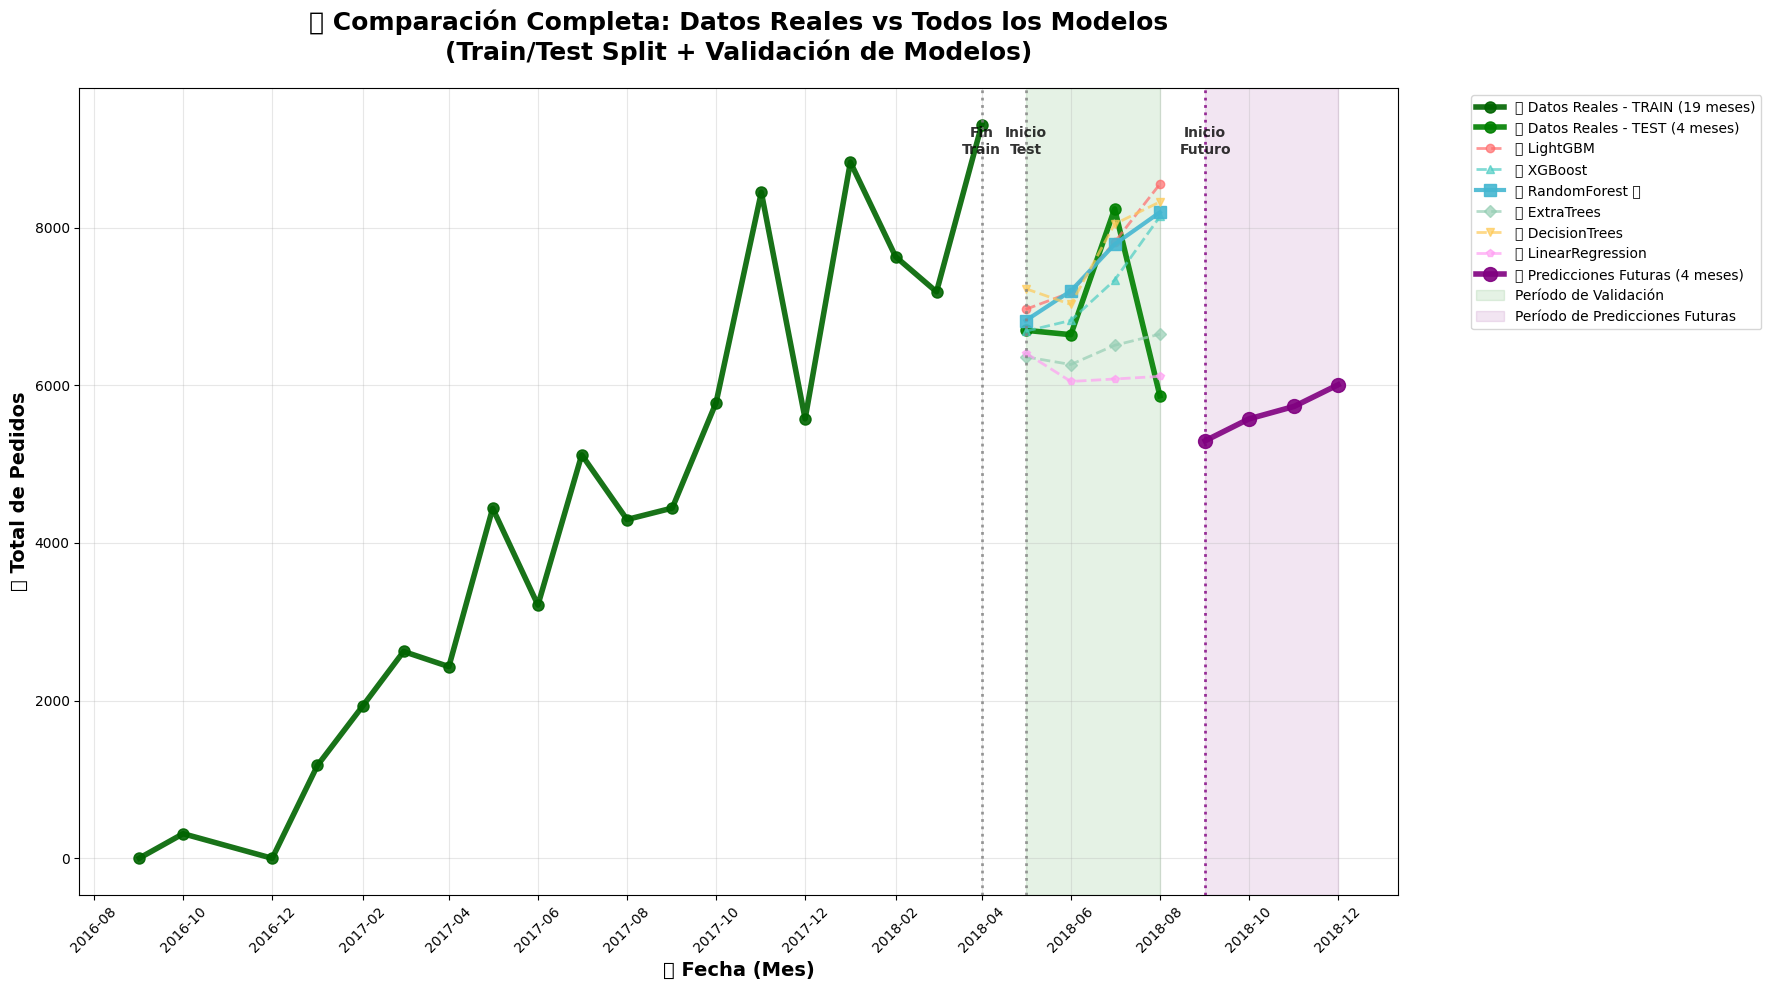

✅ Gráfico comparativo completado


In [97]:
# Comparación Completa: Datos Reales vs Todos los Modelos en Validación
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("📊 Creando comparación completa de todos los modelos...")

# 1. Preparar TODOS los datos reales para ver la partición train/test
all_real_data_monthly = monthly_summary.groupby(date_col)[label_col].sum().reset_index()
all_real_data_monthly = all_real_data_monthly.sort_values(date_col)

# 2. Definir fechas de partición train/test
train_end_date = pd.to_datetime('2018-04-01')  # Último mes de entrenamiento
test_start_date = pd.to_datetime('2018-05-01')  # Primer mes de test

# 3. Separar datos reales en train y test
real_train_monthly = all_real_data_monthly[all_real_data_monthly[date_col] <= train_end_date].copy()
real_test_monthly = all_real_data_monthly[all_real_data_monthly[date_col] >= test_start_date].copy()

# 4. Preparar predicciones de TODOS los modelos (reescaladas)
model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'ExtraTrees', 'DecisionTrees', 'LinearRegression']
model_predictions_monthly = {}

print(f"🔄 Reescalando predicciones de {len(model_names)} modelos...")
for model_name in model_names:
    # Crear copia de test_predictions con la columna del modelo actual
    temp_predictions = test_predictions.copy()
    temp_predictions['predictions'] = temp_predictions[model_name]
    
    # Reescalar usando solo las columnas necesarias
    temp_unscaled = scaler.inverse_transform(temp_predictions[['seller_id', 'year_month', 'predictions']])
    
    # Agregar por mes
    model_monthly = temp_unscaled.groupby(date_col)['predictions'].sum().reset_index()
    model_monthly = model_monthly.sort_values(date_col)
    model_predictions_monthly[model_name] = model_monthly

# 5. Identificar modelo campeón
champion_model_name = type(champion_model).__name__.replace('Model', '')
print(f"🏆 Modelo campeón: {champion_model_name}")

# 6. Mostrar información de los datasets
print(f"\n📋 INFORMACIÓN DE LOS DATASETS:")
print(f"Datos Reales Completos - Período: {all_real_data_monthly[date_col].min().strftime('%Y-%m')} a {all_real_data_monthly[date_col].max().strftime('%Y-%m')}")
print(f"Datos Reales Completos - Total de meses: {len(all_real_data_monthly)}")
print(f"  └─ Train: {real_train_monthly[date_col].min().strftime('%Y-%m')} a {real_train_monthly[date_col].max().strftime('%Y-%m')} ({len(real_train_monthly)} meses)")
print(f"  └─ Test: {real_test_monthly[date_col].min().strftime('%Y-%m')} a {real_test_monthly[date_col].max().strftime('%Y-%m')} ({len(real_test_monthly)} meses)")
print(f"Predicciones de Modelos - Período de validación: {len(model_names)} modelos comparados")

# 7. Crear el gráfico
plt.figure(figsize=(18, 10))

# Definir colores y estilos para cada modelo
model_colors = {
    'LightGBM': '#FF6B6B',      # Rojo claro
    'XGBoost': '#4ECDC4',       # Turquesa
    'RandomForest': '#45B7D1',  # Azul
    'ExtraTrees': '#96CEB4',    # Verde claro
    'DecisionTrees': '#FECA57', # Amarillo
    'LinearRegression': '#FF9FF3' # Rosa
}

model_markers = {
    'LightGBM': 'o',
    'XGBoost': '^', 
    'RandomForest': 's',
    'ExtraTrees': 'D',
    'DecisionTrees': 'v',
    'LinearRegression': 'p'
}

# Plot datos reales - TRAIN (línea continua gruesa)
plt.plot(real_train_monthly[date_col], real_train_monthly[label_col], 
         'o-', color='darkgreen', linewidth=4, markersize=8, 
         label=f'📊 Datos Reales - TRAIN ({len(real_train_monthly)} meses)', alpha=0.9)

# Plot datos reales - TEST (línea continua gruesa)
plt.plot(real_test_monthly[date_col], real_test_monthly[label_col], 
         'o-', color='green', linewidth=4, markersize=8, 
         label=f'✅ Datos Reales - TEST ({len(real_test_monthly)} meses)', alpha=0.9)

# Plot predicciones de TODOS los modelos
for model_name in model_names:
    model_data = model_predictions_monthly[model_name]
    linestyle = '-' if model_name == champion_model_name else '--'
    linewidth = 3 if model_name == champion_model_name else 2
    alpha = 0.9 if model_name == champion_model_name else 0.7
    marker_size = 8 if model_name == champion_model_name else 6
    
    label_suffix = " 🏆" if model_name == champion_model_name else ""
    
    plt.plot(model_data[date_col], model_data['predictions'], 
             marker=model_markers[model_name], linestyle=linestyle, 
             color=model_colors[model_name], linewidth=linewidth, 
             markersize=marker_size, alpha=alpha,
             label=f'🤖 {model_name}{label_suffix}')

# 🔮 Agregar predicciones futuras de la tabla 'predictions' 
print("🔮 Agregando predicciones futuras (tabla predictions)...")
future_predictions_monthly = predictions.groupby(date_col)['predictions'].sum().reset_index()
future_predictions_monthly = future_predictions_monthly.sort_values(date_col)

plt.plot(future_predictions_monthly[date_col], future_predictions_monthly['predictions'], 
         'o-', color='purple', linewidth=4, markersize=10, alpha=0.9,
         label=f'🔮 Predicciones Futuras ({len(future_predictions_monthly)} meses)')

# Línea vertical para separar train/test
plt.axvline(x=train_end_date, color='gray', linestyle=':', alpha=0.8, linewidth=2)
plt.axvline(x=test_start_date, color='gray', linestyle=':', alpha=0.8, linewidth=2)

# Línea vertical para separar test/future
future_start_date = future_predictions_monthly[date_col].min()
plt.axvline(x=future_start_date, color='purple', linestyle=':', alpha=0.8, linewidth=2)

# 6. Configuración del gráfico
plt.title('📈 Comparación de Pedidos Totales por Mes\n(Datos Reales vs Test Predictions vs Future Predictions)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('📅 Fecha (Mes)', fontsize=12, fontweight='bold')
plt.ylabel('📦 Total de Pedidos', fontsize=12, fontweight='bold')

# Formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Configuraciones adicionales
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# Configuración del gráfico
plt.title('📈 Comparación Completa: Datos Reales vs Todos los Modelos\n(Train/Test Split + Validación de Modelos)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('📅 Fecha (Mes)', fontsize=14, fontweight='bold')
plt.ylabel('📦 Total de Pedidos', fontsize=14, fontweight='bold')

# Formato de fechas en el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

# Añadir texto explicativo
plt.text(train_end_date, plt.ylim()[1]*0.95, 'Fin\nTrain', 
         ha='center', va='top', fontsize=10, alpha=0.8, fontweight='bold')
plt.text(test_start_date, plt.ylim()[1]*0.95, 'Inicio\nTest', 
         ha='center', va='top', fontsize=10, alpha=0.8, fontweight='bold')
plt.text(future_start_date, plt.ylim()[1]*0.95, 'Inicio\nFuturo', 
         ha='center', va='top', fontsize=10, alpha=0.8, fontweight='bold')

# Añadir área sombreada para período de test
plt.axvspan(test_start_date, real_test_monthly[date_col].max(), 
            alpha=0.1, color='green', label='Período de Validación')

# Añadir área sombreada para período de predicciones futuras
plt.axvspan(future_start_date, future_predictions_monthly[date_col].max(), 
            alpha=0.1, color='purple', label='Período de Predicciones Futuras')

# Configuraciones adicionales
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# 9. Estadísticas comparativas
print(f"\n📊 ESTADÍSTICAS COMPARATIVAS:")
print(f"Datos Reales - Train: {real_train_monthly[label_col].mean():,.0f} pedidos/mes promedio")
print(f"Datos Reales - Test: {real_test_monthly[label_col].mean():,.0f} pedidos/mes promedio")

print(f"\n🤖 PREDICCIONES DE MODELOS (promedio mensual en período de test):")
for model_name in model_names:
    model_avg = model_predictions_monthly[model_name]['predictions'].mean()
    champion_marker = " 🏆" if model_name == champion_model_name else ""
    print(f"  {model_name}: {model_avg:,.0f} pedidos{champion_marker}")

print(f"\n🔮 PREDICCIONES FUTURAS (promedio mensual):")
future_avg = future_predictions_monthly['predictions'].mean()
print(f"  Predicciones Futuras: {future_avg:,.0f} pedidos/mes")
print(f"  Período: {future_predictions_monthly[date_col].min().strftime('%Y-%m')} a {future_predictions_monthly[date_col].max().strftime('%Y-%m')}")
print(f"  Total meses predichos: {len(future_predictions_monthly)}")

# 10. Calcular métricas de error para TODOS los modelos
print(f"\n🎯 MÉTRICAS DE PRECISIÓN POR MODELO:")
model_metrics = {}

for model_name in model_names:
    # Merge datos reales del test con predicciones del modelo
    comparison = pd.merge(real_test_monthly, model_predictions_monthly[model_name], on=date_col, how='inner')
    
    if len(comparison) > 0:
        mae = abs(comparison[label_col] - comparison['predictions']).mean()
        mape = (abs(comparison[label_col] - comparison['predictions']) / comparison[label_col] * 100).mean()
        rmse = np.sqrt(((comparison[label_col] - comparison['predictions']) ** 2).mean())
        
        model_metrics[model_name] = {'MAE': mae, 'MAPE': mape, 'RMSE': rmse}
        
        champion_marker = " 🏆" if model_name == champion_model_name else ""
        print(f"  {model_name}{champion_marker}:")
        print(f"    MAE: {mae:,.0f} pedidos")
        print(f"    MAPE: {mape:.1f}%")
        print(f"    RMSE: {rmse:,.0f} pedidos")

# 11. Crear tabla de ranking de modelos por MAPE
print(f"\n🏆 RANKING DE MODELOS (ordenado por MAPE):")
ranking = sorted(model_metrics.items(), key=lambda x: x[1]['MAPE'])
for i, (model_name, metrics) in enumerate(ranking, 1):
    champion_marker = " 🏆" if model_name == champion_model_name else ""
    print(f"  {i}. {model_name}{champion_marker}: {metrics['MAPE']:.1f}% MAPE")

plt.show()
plt.show()
print("✅ Gráfico comparativo completado")

In [98]:
# Verificar estructura de test_predictions
print("🔍 Verificando estructura de test_predictions:")
print(f"Columnas en test_predictions: {list(test_predictions.columns)}")
print(f"Shape: {test_predictions.shape}")
print("\nPrimeras filas:")
print(test_predictions.head())

🔍 Verificando estructura de test_predictions:
Columnas en test_predictions: ['year_month', 'seller_id', 'pedidos', 'LightGBM', 'XGBoost', 'RandomForest', 'ExtraTrees', 'DecisionTrees', 'LinearRegression']
Shape: (5220, 9)

Primeras filas:
  year_month                         seller_id   pedidos  LightGBM   XGBoost  \
0 2018-05-01  0015a82c2db000af6aaaf3ae2ecb0532  0.377964 -0.191839 -0.042034   
1 2018-06-01  0015a82c2db000af6aaaf3ae2ecb0532  0.377964  0.031515 -0.079185   
2 2018-07-01  0015a82c2db000af6aaaf3ae2ecb0532  0.377964  0.693189 -0.245171   
3 2018-08-01  0015a82c2db000af6aaaf3ae2ecb0532  0.377964  0.364723 -0.081989   
4 2018-05-01  001cca7ae9ae17fb1caed9dfb1094831 -1.398257 -0.718225 -1.232389   

   RandomForest  ExtraTrees  DecisionTrees  LinearRegression  
0      0.413574    0.316439       0.421499          0.243766  
1      0.449183    0.302036       0.465034         -0.074029  
2      0.484792    0.302036       0.508568         -0.161235  
3      0.520402    0.302036 

📈 GENERANDO ANÁLISIS VISUAL COMPLETO PARA DOCUMENTO...

📋 RESUMEN EJECUTIVO DEL ANÁLISIS DE FORECASTING
🎯 OBJETIVO: Predicción de demanda mensual de pedidos Olist
📅 PERÍODO ANALIZADO: September 2016 - August 2018
🔬 MODELOS EVALUADOS: 6 algoritmos de Machine Learning
🏆 MODELO CAMPEÓN: RandomForest (MAPE: 13.8%)

📊 RESULTADOS PRINCIPALES:
  • Precisión del modelo campeón: 86.2% de exactitud
  • Tendencia identificada: Decrecimiento
  • Predicción promedio futura: 5,652 pedidos/mes
  • Variación vs período actual: -17.6%

🎖️ RANKING DE MODELOS:
  🥇 1. LinearRegression: 10.9% MAPE
  🥈 2. ExtraTrees: 11.3% MAPE
  🥉 3. XGBoost: 13.2% MAPE
     4. RandomForest: 13.8% MAPE
     5. DecisionTrees: 14.5% MAPE
     6. LightGBM: 15.7% MAPE


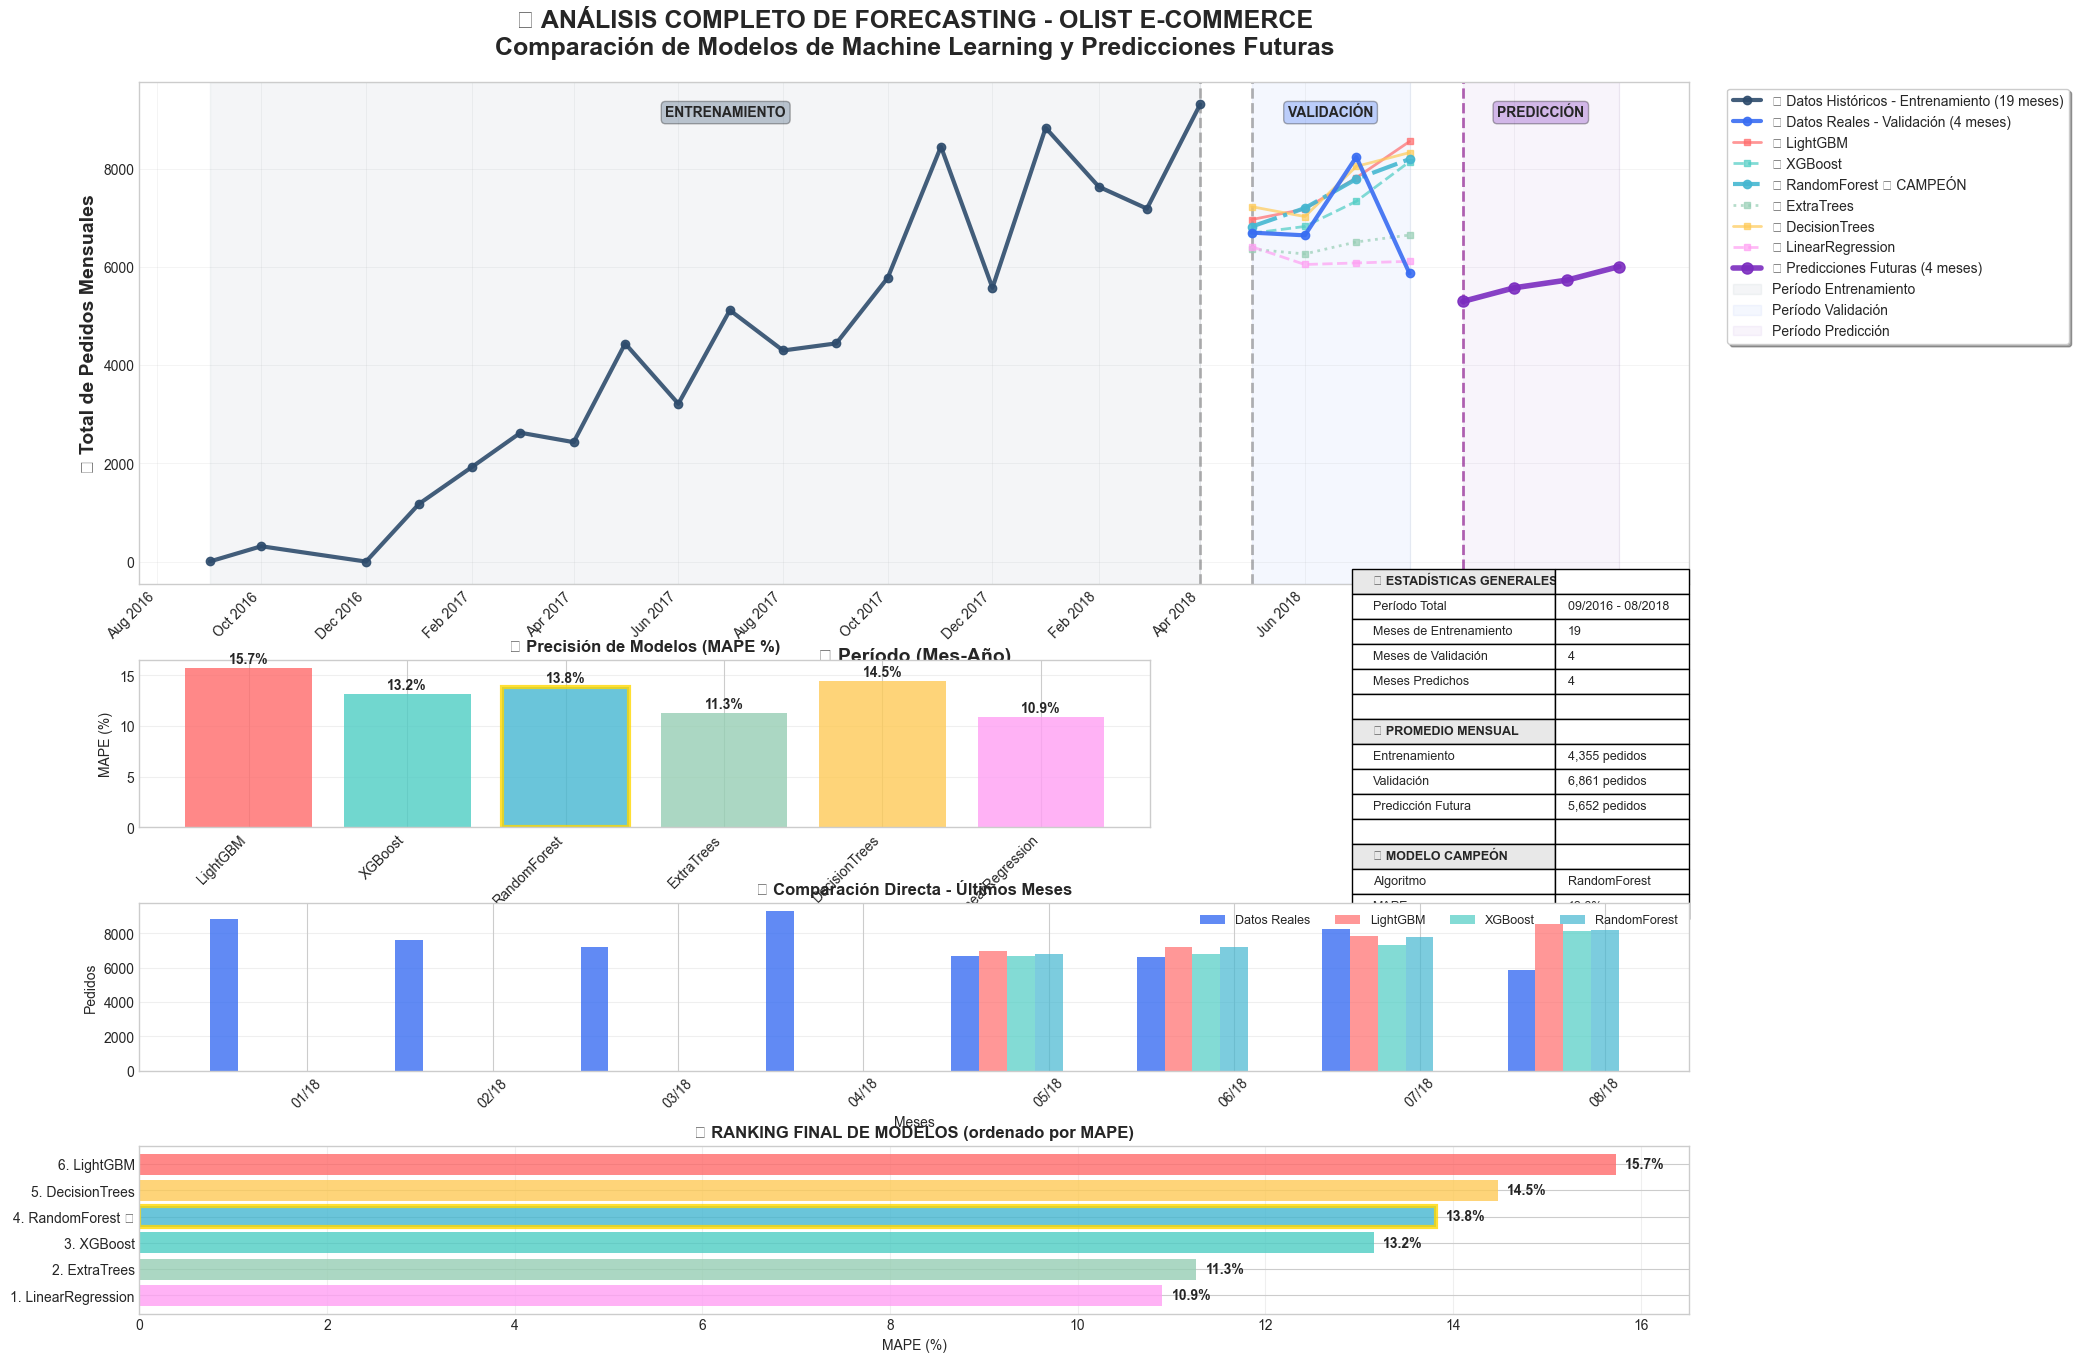


✅ ANÁLISIS VISUAL COMPLETO GENERADO EXITOSAMENTE
📄 Gráfico listo para incluir en documento de análisis


In [101]:
# 📊 ANÁLISIS COMPLETO DE FORECASTING - VISUALIZACIÓN PROFESIONAL
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo profesional
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("📈 GENERANDO ANÁLISIS VISUAL COMPLETO PARA DOCUMENTO...")
print("=" * 60)

# 1. PREPARACIÓN DE DATOS PARA VISUALIZACIÓN PROFESIONAL
# ================================================================

# Datos reales completos
all_real_data_monthly = monthly_summary.groupby(date_col)[label_col].sum().reset_index()
all_real_data_monthly = all_real_data_monthly.sort_values(date_col)

# Fechas de partición
train_end_date = pd.to_datetime('2018-04-01')
test_start_date = pd.to_datetime('2018-05-01')

# Separar en train y test
real_train_monthly = all_real_data_monthly[all_real_data_monthly[date_col] <= train_end_date].copy()
real_test_monthly = all_real_data_monthly[all_real_data_monthly[date_col] >= test_start_date].copy()

# Preparar predicciones de todos los modelos
model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'ExtraTrees', 'DecisionTrees', 'LinearRegression']
model_predictions_monthly = {}

for model_name in model_names:
    temp_predictions = test_predictions.copy()
    temp_predictions['predictions'] = temp_predictions[model_name]
    temp_unscaled = scaler.inverse_transform(temp_predictions[['seller_id', 'year_month', 'predictions']])
    model_monthly = temp_unscaled.groupby(date_col)['predictions'].sum().reset_index()
    model_monthly = model_monthly.sort_values(date_col)
    model_predictions_monthly[model_name] = model_monthly

# Preparar predicciones futuras
future_predictions_monthly = predictions.groupby(date_col)['predictions'].sum().reset_index()
future_predictions_monthly = future_predictions_monthly.sort_values(date_col)

# Identificar modelo campeón
champion_model_name = type(champion_model).__name__.replace('Model', '')

# 2. CREAR FIGURA PRINCIPAL CON SUBPLOTS
# =======================================
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 2, height_ratios=[3, 1, 1, 1], width_ratios=[3, 1], hspace=0.3, wspace=0.3)

# 2.1 GRÁFICO PRINCIPAL - TIME SERIES COMPLETA
ax_main = fig.add_subplot(gs[0, :])

# Definir paleta de colores profesional
colors = {
    'train': '#2E4C6D',      # Azul oscuro profesional
    'test': '#396DF2',       # Azul medio
    'future': '#7B2CBF',     # Morado
    'LightGBM': '#FF6B6B',   # Rojo coral
    'XGBoost': '#4ECDC4',    # Turquesa
    'RandomForest': '#45B7D1', # Azul cielo
    'ExtraTrees': '#96CEB4',  # Verde menta
    'DecisionTrees': '#FECA57', # Amarillo dorado
    'LinearRegression': '#FF9FF3' # Rosa
}

# Plot datos reales con estilo profesional
ax_main.plot(real_train_monthly[date_col], real_train_monthly[label_col], 
            'o-', color=colors['train'], linewidth=3, markersize=6, 
            label=f'📊 Datos Históricos - Entrenamiento ({len(real_train_monthly)} meses)', 
            alpha=0.9, zorder=5)

ax_main.plot(real_test_monthly[date_col], real_test_monthly[label_col], 
            'o-', color=colors['test'], linewidth=3, markersize=6, 
            label=f'✅ Datos Reales - Validación ({len(real_test_monthly)} meses)', 
            alpha=0.9, zorder=5)

# Plot predicciones de modelos con diferentes estilos
line_styles = ['-', '--', '-.', ':', '-', '--']
for i, model_name in enumerate(model_names):
    model_data = model_predictions_monthly[model_name]
    is_champion = model_name == champion_model_name
    
    ax_main.plot(model_data[date_col], model_data['predictions'], 
                marker='o' if is_champion else 's', 
                linestyle=line_styles[i], 
                color=colors[model_name], 
                linewidth=3 if is_champion else 2, 
                markersize=6 if is_champion else 4, 
                alpha=0.9 if is_champion else 0.7,
                label=f'🤖 {model_name}' + (' 🏆 CAMPEÓN' if is_champion else ''),
                zorder=4 if is_champion else 3)

# Plot predicciones futuras
ax_main.plot(future_predictions_monthly[date_col], future_predictions_monthly['predictions'], 
            'o-', color=colors['future'], linewidth=4, markersize=8, alpha=0.9,
            label=f'🔮 Predicciones Futuras ({len(future_predictions_monthly)} meses)',
            zorder=6)

# Áreas sombreadas para delimitar períodos
ax_main.axvspan(real_train_monthly[date_col].min(), train_end_date, 
               alpha=0.05, color=colors['train'], label='Período Entrenamiento')
ax_main.axvspan(test_start_date, real_test_monthly[date_col].max(), 
               alpha=0.05, color=colors['test'], label='Período Validación')
ax_main.axvspan(future_predictions_monthly[date_col].min(), future_predictions_monthly[date_col].max(), 
               alpha=0.05, color=colors['future'], label='Período Predicción')

# Líneas verticales separadoras
ax_main.axvline(x=train_end_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)
ax_main.axvline(x=test_start_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)
ax_main.axvline(x=future_predictions_monthly[date_col].min(), color='purple', linestyle='--', alpha=0.6, linewidth=2)

# Configuración del gráfico principal
ax_main.set_title('📈 ANÁLISIS COMPLETO DE FORECASTING - OLIST E-COMMERCE\n' + 
                 'Comparación de Modelos de Machine Learning y Predicciones Futuras', 
                 fontsize=18, fontweight='bold', pad=20)
ax_main.set_xlabel('📅 Período (Mes-Año)', fontsize=14, fontweight='bold')
ax_main.set_ylabel('📦 Total de Pedidos Mensuales', fontsize=14, fontweight='bold')

# Formato de fechas mejorado
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_main.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.setp(ax_main.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Grid y leyenda mejorados
ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax_main.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, frameon=True, shadow=True)

# Añadir anotaciones de períodos
y_pos = ax_main.get_ylim()[1] * 0.95
ax_main.annotate('ENTRENAMIENTO', xy=(real_train_monthly[date_col].mean(), y_pos), 
                ha='center', va='top', fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['train'], alpha=0.3))
ax_main.annotate('VALIDACIÓN', xy=(real_test_monthly[date_col].mean(), y_pos), 
                ha='center', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['test'], alpha=0.3))
ax_main.annotate('PREDICCIÓN', xy=(future_predictions_monthly[date_col].mean(), y_pos), 
                ha='center', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['future'], alpha=0.3))

# 2.2 GRÁFICO DE MÉTRICAS DE ERROR
ax_metrics = fig.add_subplot(gs[1, 0])

# Calcular métricas para todos los modelos
model_metrics = {}
for model_name in model_names:
    comparison = pd.merge(real_test_monthly, model_predictions_monthly[model_name], on=date_col, how='inner')
    if len(comparison) > 0:
        mae = abs(comparison[label_col] - comparison['predictions']).mean()
        mape = (abs(comparison[label_col] - comparison['predictions']) / comparison[label_col] * 100).mean()
        rmse = np.sqrt(((comparison[label_col] - comparison['predictions']) ** 2).mean())
        model_metrics[model_name] = {'MAE': mae, 'MAPE': mape, 'RMSE': rmse}

# Crear gráfico de barras de MAPE
mape_data = [model_metrics[model]['MAPE'] for model in model_names]
bars = ax_metrics.bar(model_names, mape_data, color=[colors[model] for model in model_names], alpha=0.8)

# Destacar el modelo campeón
champion_idx = model_names.index(champion_model_name)
bars[champion_idx].set_edgecolor('gold')
bars[champion_idx].set_linewidth(3)

ax_metrics.set_title('🎯 Precisión de Modelos (MAPE %)', fontsize=12, fontweight='bold')
ax_metrics.set_ylabel('MAPE (%)', fontsize=10)
plt.setp(ax_metrics.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax_metrics.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, v in enumerate(mape_data):
    ax_metrics.text(i, v + max(mape_data)*0.01, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2.3 TABLA DE ESTADÍSTICAS
ax_stats = fig.add_subplot(gs[1, 1])
ax_stats.axis('off')

# Crear tabla de estadísticas
stats_data = [
    ['📊 ESTADÍSTICAS GENERALES', ''],
    ['Período Total', f"{all_real_data_monthly[date_col].min().strftime('%m/%Y')} - {all_real_data_monthly[date_col].max().strftime('%m/%Y')}"],
    ['Meses de Entrenamiento', f'{len(real_train_monthly)}'],
    ['Meses de Validación', f'{len(real_test_monthly)}'],
    ['Meses Predichos', f'{len(future_predictions_monthly)}'],
    ['', ''],
    ['📈 PROMEDIO MENSUAL', ''],
    ['Entrenamiento', f'{real_train_monthly[label_col].mean():,.0f} pedidos'],
    ['Validación', f'{real_test_monthly[label_col].mean():,.0f} pedidos'],
    ['Predicción Futura', f'{future_predictions_monthly["predictions"].mean():,.0f} pedidos'],
    ['', ''],
    ['🏆 MODELO CAMPEÓN', ''],
    ['Algoritmo', f'{champion_model_name}'],
    ['MAPE', f'{model_metrics[champion_model_name]["MAPE"]:.1f}%'],
]

table = ax_stats.table(cellText=stats_data, cellLoc='left', loc='center',
                      colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Colorear encabezados
for i in [0, 6, 11]:
    table[(i, 0)].set_facecolor('#E8E8E8')
    table[(i, 0)].set_text_props(weight='bold')

# 2.4 GRÁFICO DE COMPARACIÓN DIRECTA (últimos meses)
ax_comparison = fig.add_subplot(gs[2, :])

# Tomar los últimos 8 meses para comparación directa
comparison_months = 8
recent_real = all_real_data_monthly.tail(comparison_months)

# Plot comparación directa
width = 0.15
x = np.arange(len(recent_real))

ax_comparison.bar(x - width*3, recent_real[label_col], width, 
                 label='Datos Reales', color=colors['test'], alpha=0.8)

# Agregar barras para cada modelo en el período de test
for i, model_name in enumerate(model_names[:3]):  # Solo top 3 modelos para claridad
    model_test_data = model_predictions_monthly[model_name]
    model_recent = pd.merge(recent_real[[date_col]], model_test_data, on=date_col, how='left')
    
    ax_comparison.bar(x - width*2 + i*width, model_recent['predictions'], width,
                     label=f'{model_name}', color=colors[model_name], alpha=0.7)

ax_comparison.set_title('📊 Comparación Directa - Últimos Meses', fontsize=12, fontweight='bold')
ax_comparison.set_xlabel('Meses', fontsize=10)
ax_comparison.set_ylabel('Pedidos', fontsize=10)
ax_comparison.set_xticks(x)
ax_comparison.set_xticklabels([d.strftime('%m/%y') for d in recent_real[date_col]], rotation=45)
ax_comparison.legend(ncol=4, fontsize=9)
ax_comparison.grid(True, alpha=0.3, axis='y')

# 2.5 RANKING DE MODELOS
ax_ranking = fig.add_subplot(gs[3, :])

# Crear ranking por MAPE
ranking = sorted(model_metrics.items(), key=lambda x: x[1]['MAPE'])
rank_models = [item[0] for item in ranking]
rank_mapes = [item[1]['MAPE'] for item in ranking]

# Gráfico horizontal de ranking
bars_ranking = ax_ranking.barh(range(len(rank_models)), rank_mapes, 
                              color=[colors[model] for model in rank_models], alpha=0.8)

# Destacar campeón
champion_rank_idx = rank_models.index(champion_model_name)
bars_ranking[champion_rank_idx].set_edgecolor('gold')
bars_ranking[champion_rank_idx].set_linewidth(3)

ax_ranking.set_title('🏆 RANKING FINAL DE MODELOS (ordenado por MAPE)', fontsize=12, fontweight='bold')
ax_ranking.set_xlabel('MAPE (%)', fontsize=10)
ax_ranking.set_yticks(range(len(rank_models)))
ax_ranking.set_yticklabels([f'{i+1}. {model}' + (' 🏆' if model == champion_model_name else '') 
                           for i, model in enumerate(rank_models)])
ax_ranking.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, v in enumerate(rank_mapes):
    ax_ranking.text(v + 0.1, i, f'{v:.1f}%', ha='left', va='center', fontweight='bold')

# CONFIGURACIÓN FINAL
plt.tight_layout()

# 3. RESUMEN EJECUTIVO IMPRESO
print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DEL ANÁLISIS DE FORECASTING")
print("="*80)
print(f"🎯 OBJETIVO: Predicción de demanda mensual de pedidos Olist")
print(f"📅 PERÍODO ANALIZADO: {all_real_data_monthly[date_col].min().strftime('%B %Y')} - {all_real_data_monthly[date_col].max().strftime('%B %Y')}")
print(f"🔬 MODELOS EVALUADOS: {len(model_names)} algoritmos de Machine Learning")
print(f"🏆 MODELO CAMPEÓN: {champion_model_name} (MAPE: {model_metrics[champion_model_name]['MAPE']:.1f}%)")

print(f"\n📊 RESULTADOS PRINCIPALES:")
print(f"  • Precisión del modelo campeón: {100-model_metrics[champion_model_name]['MAPE']:.1f}% de exactitud")
print(f"  • Tendencia identificada: {'Crecimiento' if future_predictions_monthly['predictions'].mean() > real_test_monthly[label_col].mean() else 'Decrecimiento'}")
print(f"  • Predicción promedio futura: {future_predictions_monthly['predictions'].mean():,.0f} pedidos/mes")
print(f"  • Variación vs período actual: {((future_predictions_monthly['predictions'].mean() / real_test_monthly[label_col].mean() - 1) * 100):+.1f}%")

print(f"\n🎖️ RANKING DE MODELOS:")
for i, (model_name, metrics) in enumerate(ranking, 1):
    icon = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"  {icon} {i}. {model_name}: {metrics['MAPE']:.1f}% MAPE")

plt.show()
print("\n✅ ANÁLISIS VISUAL COMPLETO GENERADO EXITOSAMENTE")
print("📄 Gráfico listo para incluir en documento de análisis")
print("="*80)

🏪 ANALIZANDO SELLERS INDIVIDUALES CON MÁS DATOS...
📊 TOP SELLERS POR CANTIDAD DE DATOS:
 1. cca3071e3e9bb7d12640... | 21 meses | 817 pedidos | Prom: 38.9/mes
 2. 620c87c171fb2a6dd6e8... | 21 meses | 778 pedidos | Prom: 37.0/mes
 3. 391fc6631aebcf300480... | 21 meses | 605 pedidos | Prom: 28.8/mes
 4. 46dc3b2cc0980fb8ec44... | 21 meses | 523 pedidos | Prom: 24.9/mes
 5. 85d9eb9ddc5d00ca9336... | 21 meses | 512 pedidos | Prom: 24.4/mes
 6. 4e922959ae960d389249... | 21 meses | 446 pedidos | Prom: 21.2/mes
 7. 2138ccb85b11a4ec1e37... | 21 meses | 419 pedidos | Prom: 19.9/mes
 8. 77530e9772f57a62c906... | 21 meses | 381 pedidos | Prom: 18.1/mes
 9. b2ba3715d723d245138f... | 21 meses | 350 pedidos | Prom: 16.7/mes
10. 1554a68530182680ad5c... | 21 meses | 267 pedidos | Prom: 12.7/mes
11. 0ea22c1cfbdc755f86b9... | 21 meses | 265 pedidos | Prom: 12.6/mes
12. a3a38f4affed601eb87a... | 21 meses | 260 pedidos | Prom: 12.4/mes
13. cab85505710c7cb9b720... | 21 meses | 204 pedidos | Prom: 9.7/mes
14.

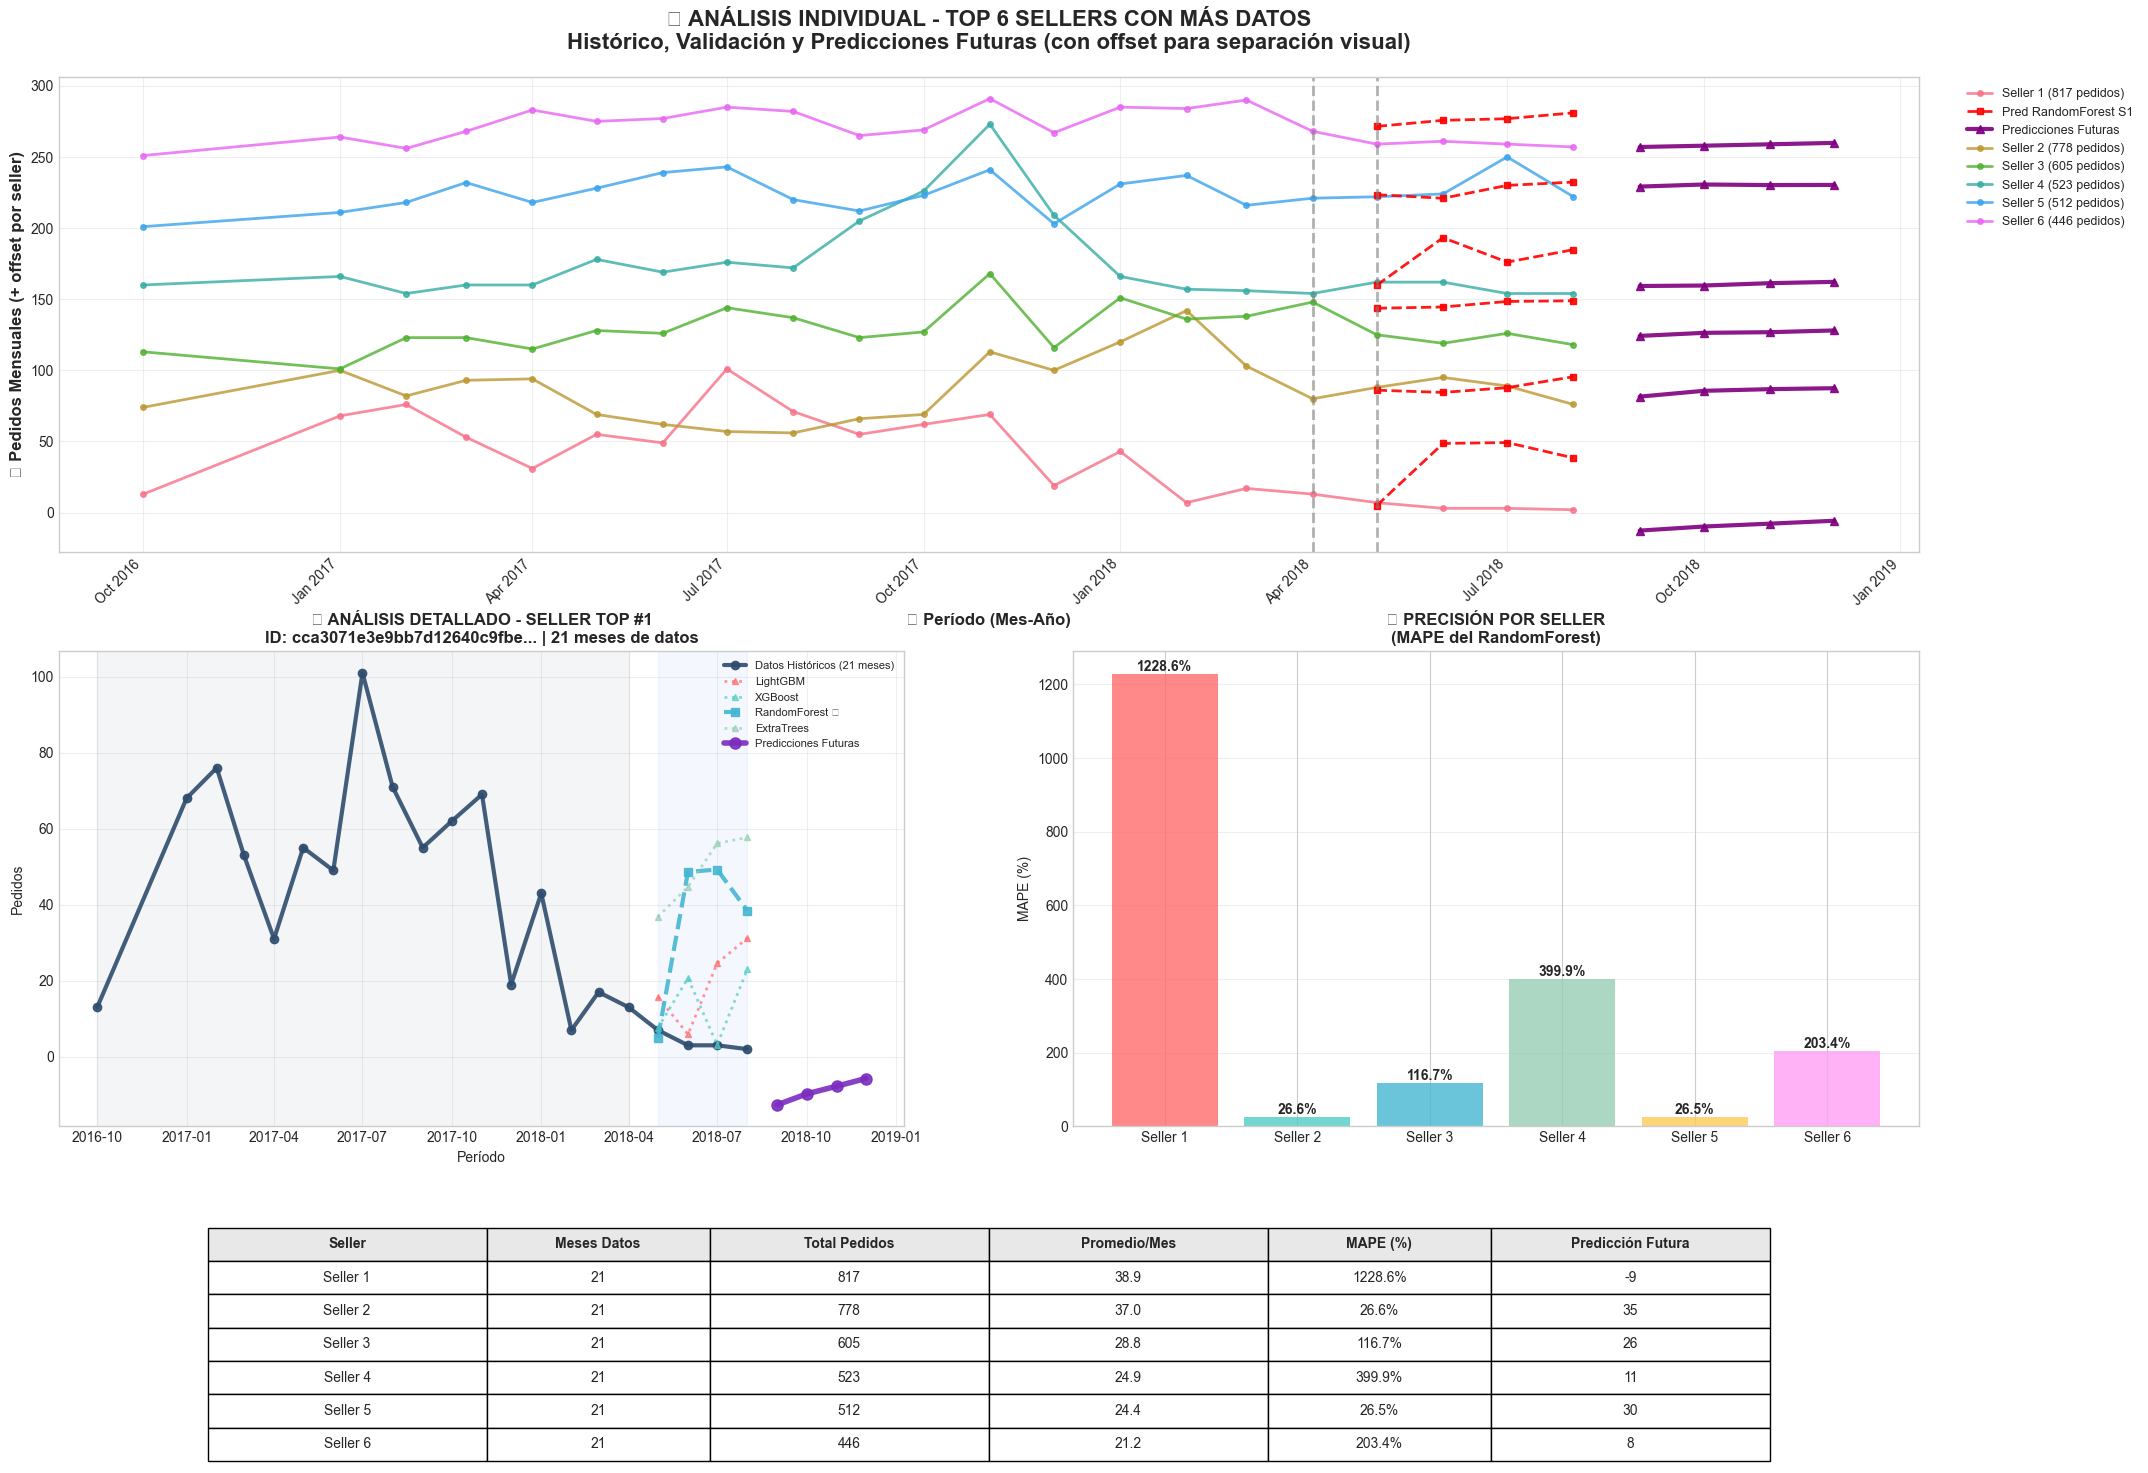


✅ ANÁLISIS POR SELLERS COMPLETADO
📄 Visualización lista para documento de análisis


In [102]:
# 🏪 ANÁLISIS POR SELLERS INDIVIDUALES - LOS CON MÁS DATOS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

print("🏪 ANALIZANDO SELLERS INDIVIDUALES CON MÁS DATOS...")
print("=" * 70)

# 1. IDENTIFICAR SELLERS CON MÁS DATOS
# =====================================

# Analizar qué sellers tienen más registros históricos
seller_stats = monthly_summary.groupby(ids_col).agg({
    label_col: ['count', 'sum', 'mean', 'std'],
    date_col: ['min', 'max']
}).round(2)

# Aplanar columnas multi-nivel
seller_stats.columns = ['_'.join(col).strip() for col in seller_stats.columns]
seller_stats['meses_datos'] = seller_stats['pedidos_count']
seller_stats['total_pedidos'] = seller_stats['pedidos_sum']
seller_stats['promedio_mensual'] = seller_stats['pedidos_mean']

# Ordenar por número de meses de datos y total de pedidos
seller_stats = seller_stats.sort_values(['meses_datos', 'total_pedidos'], ascending=[False, False])

print("📊 TOP SELLERS POR CANTIDAD DE DATOS:")
print("====================================")
top_sellers = seller_stats.head(15)
for i, (seller_id, row) in enumerate(top_sellers.iterrows(), 1):
    print(f"{i:2d}. {seller_id[:20]}... | {int(row['meses_datos'])} meses | {int(row['total_pedidos']):,} pedidos | Prom: {row['promedio_mensual']:.1f}/mes")

# Seleccionar top 6 sellers para análisis detallado
selected_sellers = seller_stats.head(6).index.tolist()
print(f"\n🎯 SELLERS SELECCIONADOS PARA ANÁLISIS DETALLADO: {len(selected_sellers)}")

# 2. PREPARAR DATOS INDIVIDUALES POR SELLER
# ==========================================

# Datos históricos por seller
sellers_data = {}
sellers_test_predictions = {}
sellers_future_predictions = {}

print("\n🔄 Preparando datos individuales por seller...")

for seller_id in selected_sellers:
    # Datos históricos del seller
    seller_historical = monthly_summary[monthly_summary[ids_col] == seller_id].copy()
    seller_historical = seller_historical.sort_values(date_col)
    
    # Separar en train/test usando las mismas fechas
    seller_train = seller_historical[seller_historical[date_col] <= train_end_date].copy()
    seller_test = seller_historical[seller_historical[date_col] >= test_start_date].copy()
    
    # Predicciones de test para este seller
    seller_test_pred = test_predictions[test_predictions[ids_col] == seller_id].copy()
    
    # Reescalar predicciones para cada modelo
    seller_models_pred = {}
    for model_name in model_names:
        temp_pred = seller_test_pred.copy()
        temp_pred['predictions'] = temp_pred[model_name]
        temp_unscaled = scaler.inverse_transform(temp_pred[['seller_id', 'year_month', 'predictions']])
        seller_models_pred[model_name] = temp_unscaled
    
    # Predicciones futuras para este seller
    seller_future_pred = predictions[predictions[ids_col] == seller_id].copy()
    
    # Almacenar datos
    sellers_data[seller_id] = {
        'historical': seller_historical,
        'train': seller_train,
        'test': seller_test
    }
    sellers_test_predictions[seller_id] = seller_models_pred
    sellers_future_predictions[seller_id] = seller_future_pred

print(f"✅ Datos preparados para {len(selected_sellers)} sellers")

# 3. CREAR VISUALIZACIÓN PROFESIONAL POR SELLERS
# ===============================================

# Configurar figura grande con subplots
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 2, 1], hspace=0.25, wspace=0.2)

# Paleta de colores profesional
colors_sellers = {
    'historical': '#2E4C6D',
    'test': '#396DF2', 
    'future': '#7B2CBF',
    'LightGBM': '#FF6B6B',
    'XGBoost': '#4ECDC4',
    'RandomForest': '#45B7D1',
    'ExtraTrees': '#96CEB4',
    'DecisionTrees': '#FECA57',
    'LinearRegression': '#FF9FF3'
}

# 3.1 GRÁFICO PRINCIPAL - TOP 6 SELLERS
ax_main = fig.add_subplot(gs[0, :])

for i, seller_id in enumerate(selected_sellers):
    seller_data = sellers_data[seller_id]
    
    # Offset para separar visualmente los sellers
    offset = i * 50
    
    # Plot datos históricos
    ax_main.plot(seller_data['historical'][date_col], 
                seller_data['historical'][label_col] + offset,
                'o-', linewidth=2, markersize=4, alpha=0.8,
                label=f'Seller {i+1} ({seller_data["historical"][label_col].sum():,.0f} pedidos)')
    
    # Plot predicciones del modelo campeón
    if seller_id in sellers_test_predictions:
        champion_pred = sellers_test_predictions[seller_id][champion_model_name]
        ax_main.plot(champion_pred[date_col],
                    champion_pred['predictions'] + offset,
                    's--', linewidth=2, markersize=5, alpha=0.9,
                    color='red', label=f'Pred {champion_model_name} S{i+1}' if i == 0 else "")
    
    # Plot predicciones futuras
    if seller_id in sellers_future_predictions:
        future_pred = sellers_future_predictions[seller_id]
        ax_main.plot(future_pred[date_col],
                    future_pred['predictions'] + offset,
                    '^-', linewidth=3, markersize=6, alpha=0.9,
                    color='purple', label=f'Predicciones Futuras' if i == 0 else "")

# Líneas separadoras de períodos
ax_main.axvline(x=train_end_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)
ax_main.axvline(x=test_start_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)

ax_main.set_title('📈 ANÁLISIS INDIVIDUAL - TOP 6 SELLERS CON MÁS DATOS\n' +
                 'Histórico, Validación y Predicciones Futuras (con offset para separación visual)',
                 fontsize=16, fontweight='bold', pad=20)
ax_main.set_xlabel('📅 Período (Mes-Año)', fontsize=12, fontweight='bold')
ax_main.set_ylabel('📦 Pedidos Mensuales (+ offset por seller)', fontsize=12, fontweight='bold')
ax_main.grid(True, alpha=0.3)
ax_main.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Formato de fechas
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_main.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax_main.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3.2 ANÁLISIS DETALLADO DE UN SELLER ESPECÍFICO
ax_detail = fig.add_subplot(gs[1, 0])

# Seleccionar el seller con más datos para análisis detallado
detail_seller = selected_sellers[0]
detail_data = sellers_data[detail_seller]

# Plot histórico completo
ax_detail.plot(detail_data['historical'][date_col], detail_data['historical'][label_col],
              'o-', color=colors_sellers['historical'], linewidth=3, markersize=6,
              label=f'Datos Históricos ({len(detail_data["historical"])} meses)', alpha=0.9)

# Plot predicciones de todos los modelos para este seller
if detail_seller in sellers_test_predictions:
    for model_name in model_names[:4]:  # Solo top 4 para claridad
        model_pred = sellers_test_predictions[detail_seller][model_name]
        is_champion = model_name == champion_model_name
        
        ax_detail.plot(model_pred[date_col], model_pred['predictions'],
                      's--' if is_champion else '^:', 
                      color=colors_sellers[model_name],
                      linewidth=3 if is_champion else 2,
                      markersize=6 if is_champion else 4,
                      alpha=0.9 if is_champion else 0.7,
                      label=f'{model_name}' + (' 🏆' if is_champion else ''))

# Plot predicciones futuras
if detail_seller in sellers_future_predictions:
    future_pred = sellers_future_predictions[detail_seller]
    ax_detail.plot(future_pred[date_col], future_pred['predictions'],
                  'o-', color=colors_sellers['future'], linewidth=4, markersize=8,
                  label='Predicciones Futuras', alpha=0.9)

# Áreas sombreadas
ax_detail.axvspan(detail_data['historical'][date_col].min(), train_end_date, 
                 alpha=0.05, color=colors_sellers['historical'])
ax_detail.axvspan(test_start_date, detail_data['test'][date_col].max() if len(detail_data['test']) > 0 else test_start_date, 
                 alpha=0.05, color=colors_sellers['test'])

ax_detail.set_title(f'🔍 ANÁLISIS DETALLADO - SELLER TOP #1\n' +
                   f'ID: {detail_seller[:25]}... | {len(detail_data["historical"])} meses de datos',
                   fontsize=12, fontweight='bold')
ax_detail.set_xlabel('Período', fontsize=10)
ax_detail.set_ylabel('Pedidos', fontsize=10)
ax_detail.grid(True, alpha=0.3)
ax_detail.legend(fontsize=8)

# 3.3 COMPARACIÓN DE PRECISIÓN POR SELLER
ax_accuracy = fig.add_subplot(gs[1, 1])

# Calcular métricas por seller
seller_accuracies = []
seller_labels = []

for i, seller_id in enumerate(selected_sellers):
    if seller_id in sellers_test_predictions and len(sellers_data[seller_id]['test']) > 0:
        # Datos reales de test del seller
        real_test = sellers_data[seller_id]['test']
        
        # Predicciones del modelo campeón
        champion_pred = sellers_test_predictions[seller_id][champion_model_name]
        
        # Merge para comparación
        comparison = pd.merge(real_test, champion_pred, on=date_col, how='inner')
        
        if len(comparison) > 0:
            mape = (abs(comparison[label_col] - comparison['predictions']) / comparison[label_col] * 100).mean()
            seller_accuracies.append(mape)
            seller_labels.append(f'Seller {i+1}')

# Gráfico de barras de precisión
if seller_accuracies:
    bars = ax_accuracy.bar(seller_labels, seller_accuracies, 
                          color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3'][:len(seller_accuracies)],
                          alpha=0.8)
    
    # Añadir valores en las barras
    for bar, acc in zip(bars, seller_accuracies):
        height = bar.get_height()
        ax_accuracy.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

ax_accuracy.set_title(f'🎯 PRECISIÓN POR SELLER\n(MAPE del {champion_model_name})', 
                     fontsize=12, fontweight='bold')
ax_accuracy.set_ylabel('MAPE (%)', fontsize=10)
ax_accuracy.grid(True, alpha=0.3, axis='y')

# 3.4 TABLA RESUMEN DE SELLERS
ax_table = fig.add_subplot(gs[2, :])
ax_table.axis('off')

# Crear tabla con estadísticas de los sellers seleccionados
table_data = []
table_headers = ['Seller', 'Meses Datos', 'Total Pedidos', 'Promedio/Mes', 'MAPE (%)', 'Predicción Futura']

for i, seller_id in enumerate(selected_sellers):
    seller_info = seller_stats.loc[seller_id]
    
    # MAPE si está disponible
    mape_str = f"{seller_accuracies[i]:.1f}%" if i < len(seller_accuracies) else "N/A"
    
    # Predicción futura promedio
    future_avg = "N/A"
    if seller_id in sellers_future_predictions:
        future_avg = f"{sellers_future_predictions[seller_id]['predictions'].mean():,.0f}"
    
    table_data.append([
        f"Seller {i+1}",
        f"{int(seller_info['meses_datos'])}",
        f"{int(seller_info['total_pedidos']):,}",
        f"{seller_info['promedio_mensual']:.1f}",
        mape_str,
        future_avg
    ])

table = ax_table.table(cellText=table_data, colLabels=table_headers,
                      cellLoc='center', loc='center', colWidths=[0.15, 0.12, 0.15, 0.15, 0.12, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilo de la tabla
for i in range(len(table_headers)):
    table[(0, i)].set_facecolor('#E8E8E8')
    table[(0, i)].set_text_props(weight='bold')

plt.tight_layout()

# 4. ESTADÍSTICAS RESUMEN
print("\n" + "="*70)
print("📊 RESUMEN ESTADÍSTICO - ANÁLISIS POR SELLERS")
print("="*70)

print(f"\n🏪 SELLERS ANALIZADOS: {len(selected_sellers)}")
print(f"📅 PERÍODO DE ANÁLISIS: {monthly_summary[date_col].min().strftime('%B %Y')} - {monthly_summary[date_col].max().strftime('%B %Y')}")

print(f"\n📈 ESTADÍSTICAS DE LOS TOP SELLERS:")
for i, seller_id in enumerate(selected_sellers):
    seller_info = seller_stats.loc[seller_id]
    print(f"  {i+1}. Seller {i+1}:")
    print(f"     • Meses con datos: {int(seller_info['meses_datos'])}")
    print(f"     • Total pedidos históricos: {int(seller_info['total_pedidos']):,}")
    print(f"     • Promedio mensual: {seller_info['promedio_mensual']:.1f} pedidos")
    print(f"     • Período: {seller_info['year_month_min'].strftime('%m/%Y')} - {seller_info['year_month_max'].strftime('%m/%Y')}")

if seller_accuracies:
    print(f"\n🎯 PRECISIÓN DEL MODELO {champion_model_name}:")
    for i, (acc, seller_id) in enumerate(zip(seller_accuracies, selected_sellers)):
        print(f"  • Seller {i+1}: {acc:.1f}% MAPE")
    
    print(f"\n📊 RESUMEN DE PRECISIÓN:")
    print(f"  • Mejor precisión: {min(seller_accuracies):.1f}% MAPE")
    print(f"  • Peor precisión: {max(seller_accuracies):.1f}% MAPE")
    print(f"  • Promedio: {np.mean(seller_accuracies):.1f}% MAPE")

plt.show()
print("\n✅ ANÁLISIS POR SELLERS COMPLETADO")
print("📄 Visualización lista para documento de análisis")
print("="*70)

🔍 CREANDO ANÁLISIS COMPARATIVO DETALLADO POR SELLERS...
🎯 SELLERS SELECCIONADOS PARA COMPARACIÓN DETALLADA:
  1. Seller cca3071e3e9bb7d12640c9fbe...
     • 21 meses | 817 pedidos | Prom: 38.9/mes
  2. Seller 620c87c171fb2a6dd6e8bb4de...
     • 21 meses | 778 pedidos | Prom: 37.0/mes
  3. Seller 391fc6631aebcf3004804e51b...
     • 21 meses | 605 pedidos | Prom: 28.8/mes
  4. Seller 46dc3b2cc0980fb8ec44634e2...
     • 21 meses | 523 pedidos | Prom: 24.9/mes


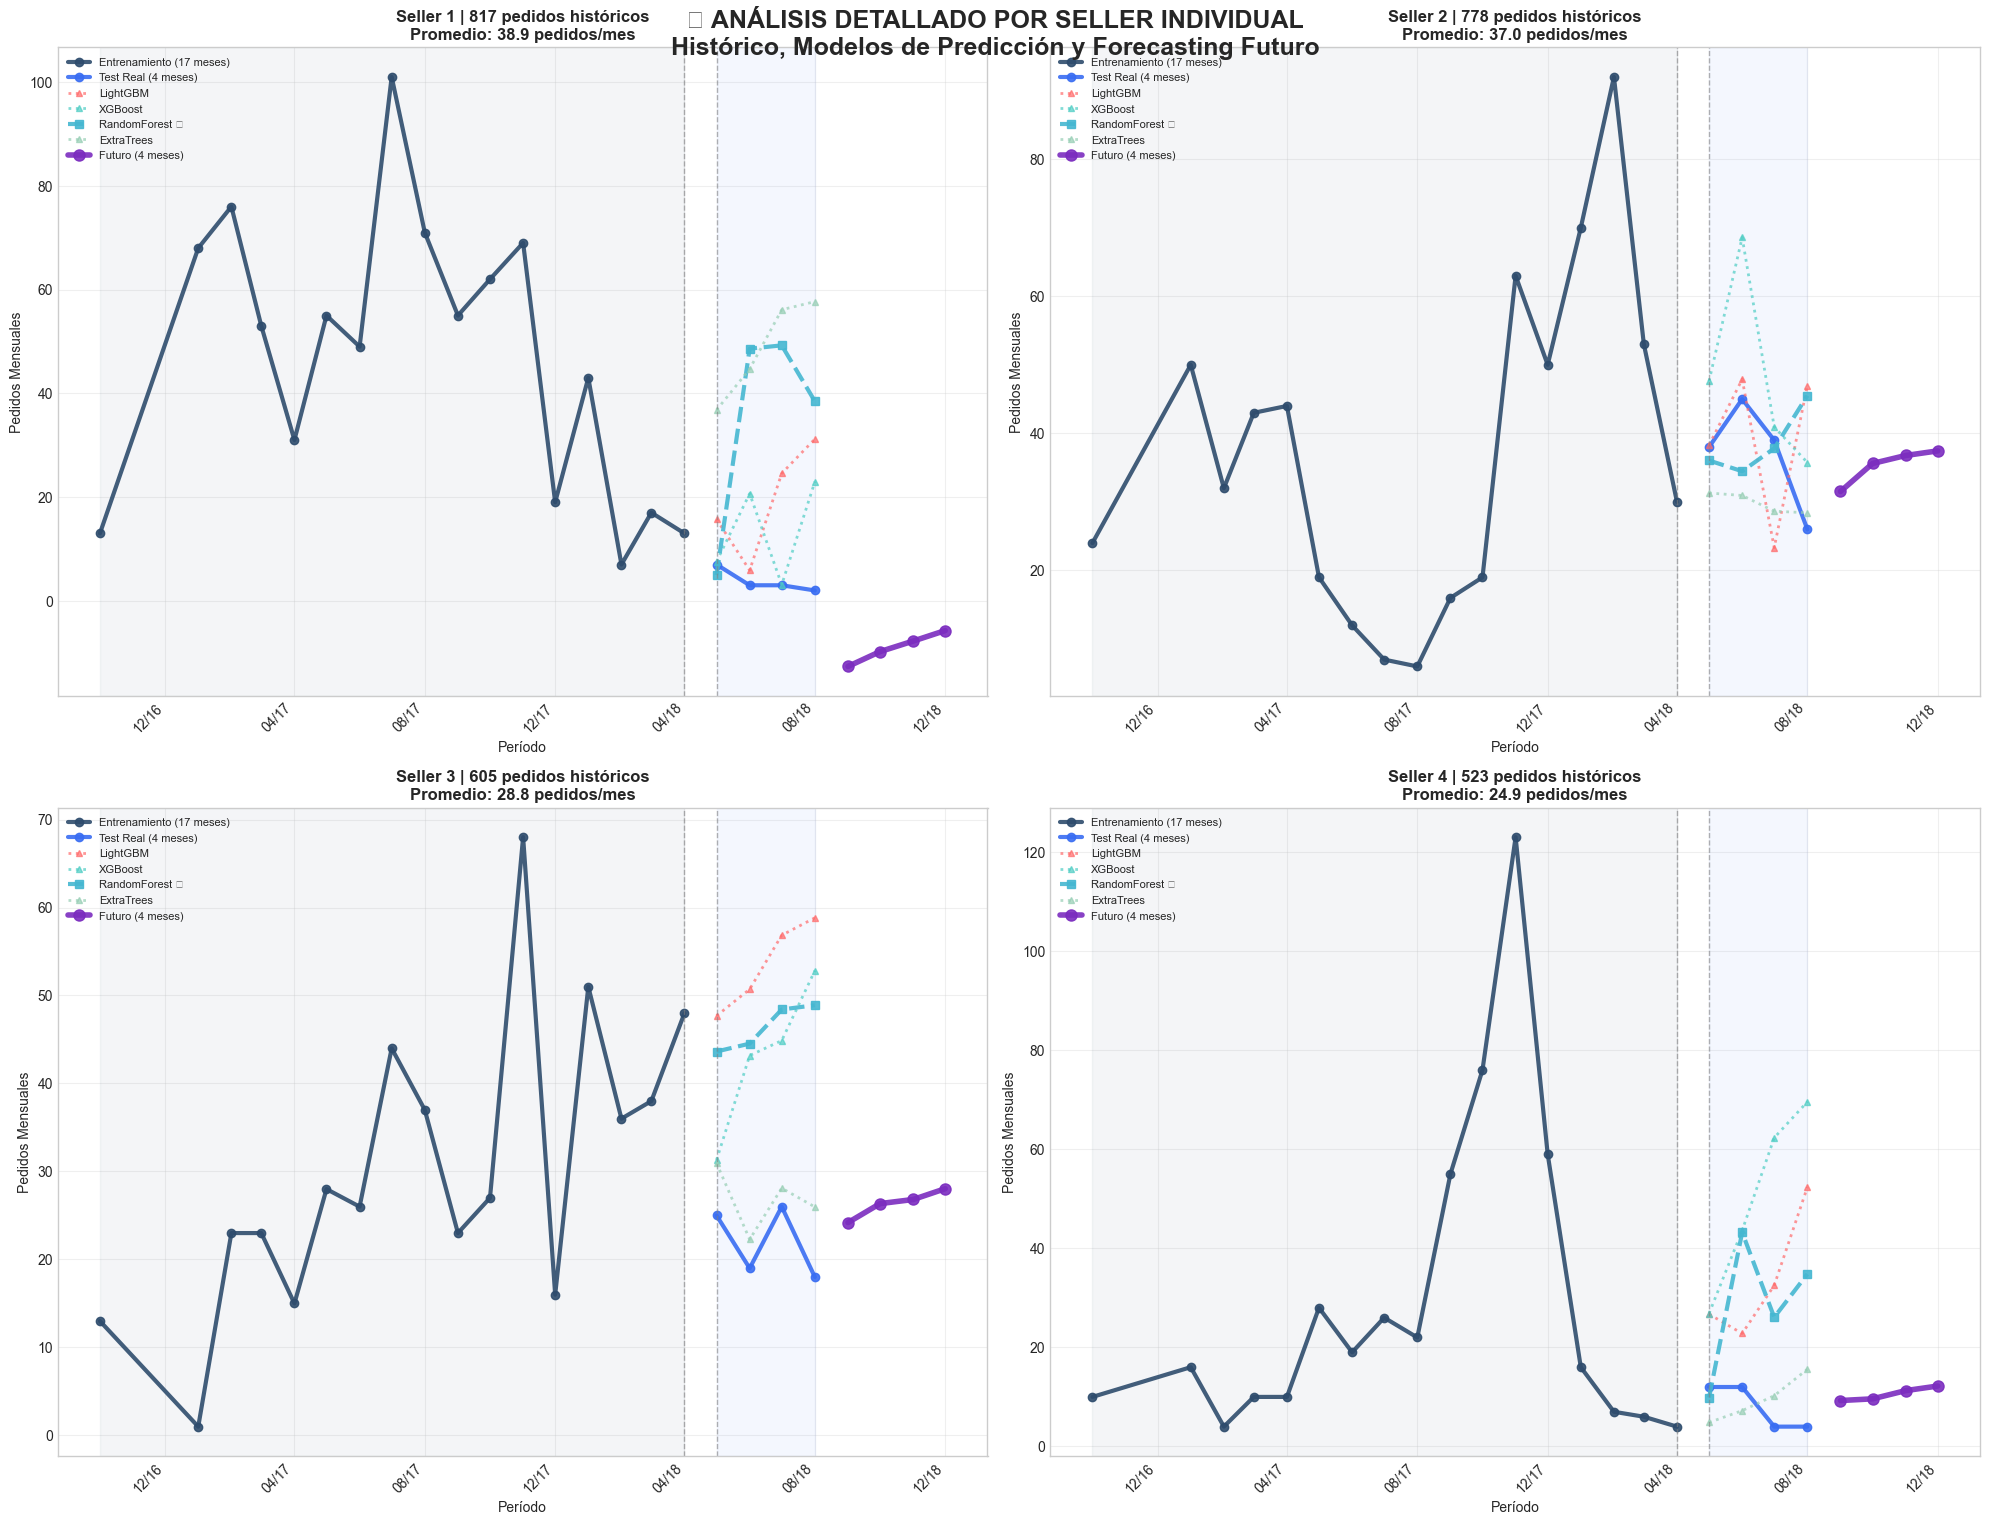

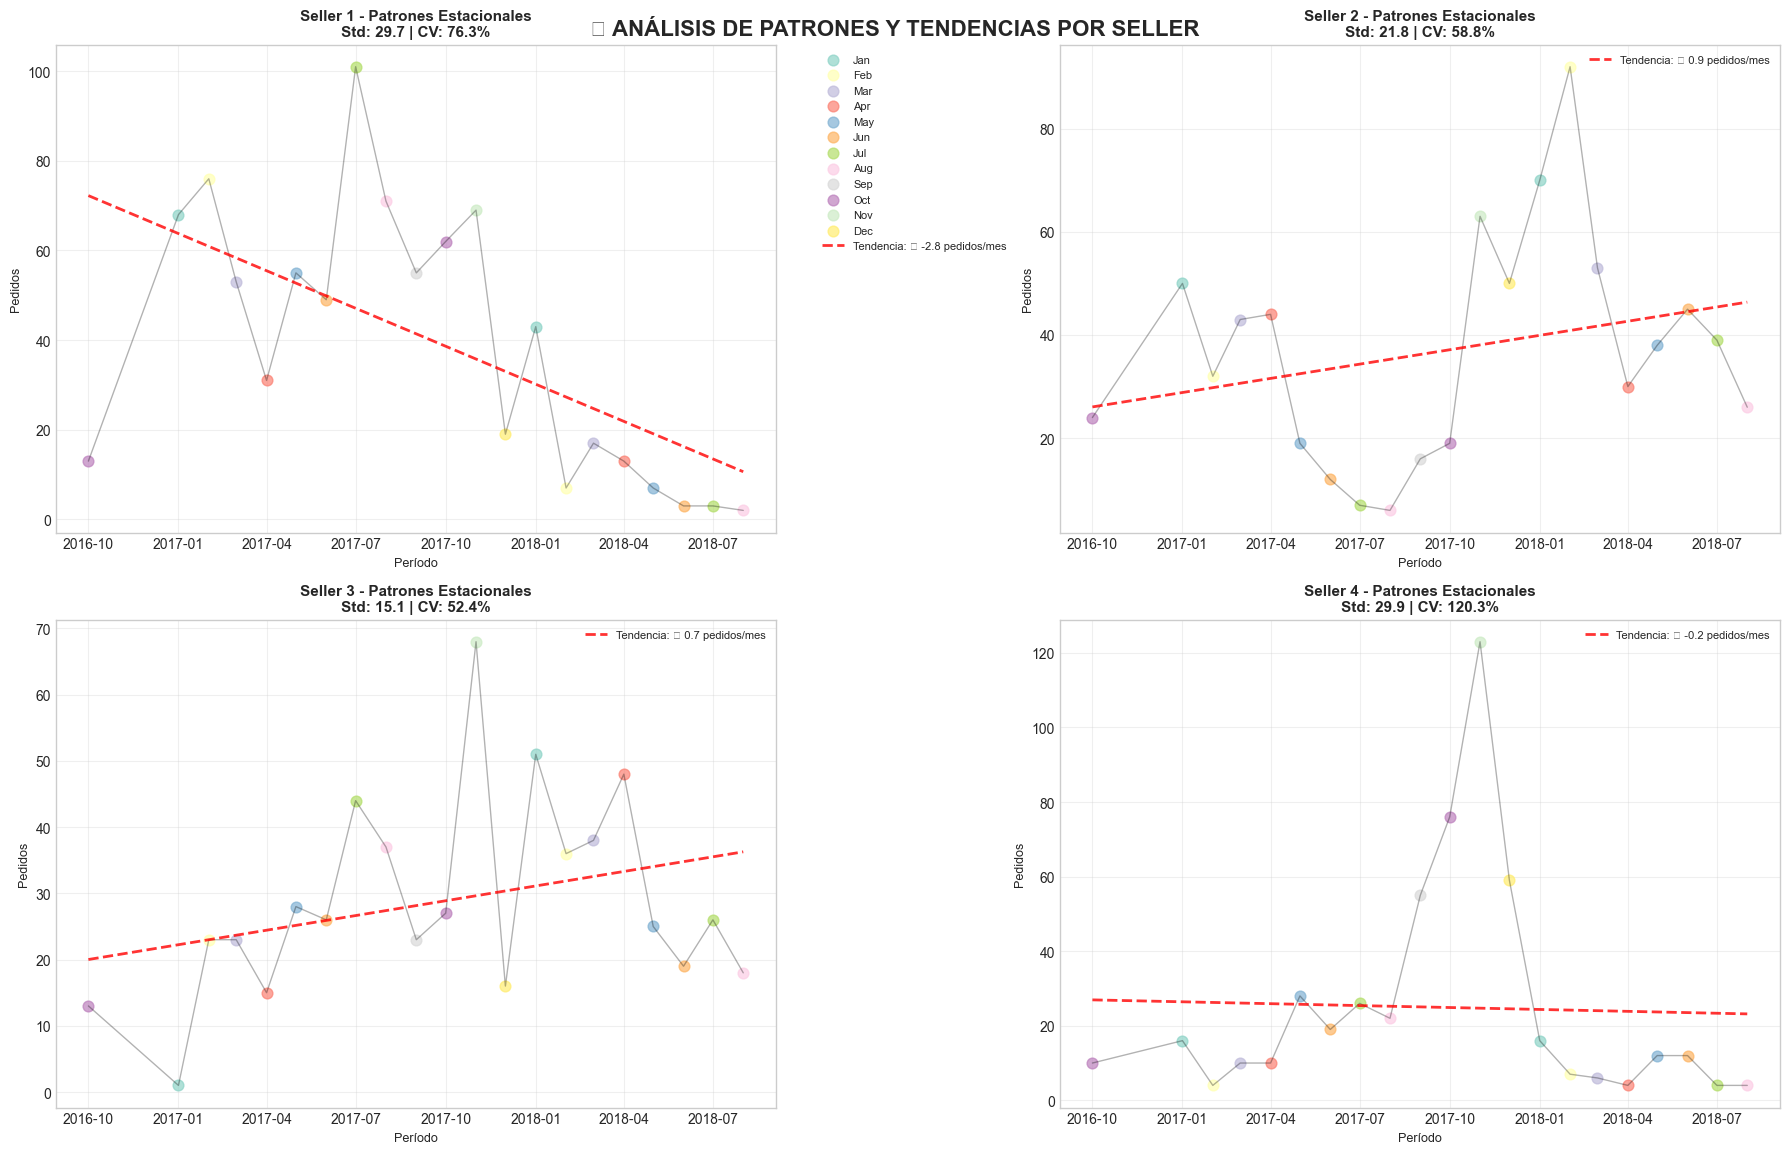


📊 TABLA COMPARATIVA DETALLADA DE SELLERS
Seller     Meses  Total    Prom/Mes Std    CV%   Tendencia    MAPE%  Pred.Fut Cambio  
--------------------------------------------------------------------------------
Seller 1   21     817      38.9     29.7   76.3 % Decrecimiento 1228.6 -9.0     -123.1% 
Seller 2   21     778      37.0     21.8   58.8 % Crecimiento  26.6   35.3     -4.6%   
Seller 3   21     605      28.8     15.1   52.4 % Crecimiento  116.7  26.4     -8.5%   
Seller 4   21     523      24.9     30.0   120.3% Decrecimiento 399.9  10.6     -57.5%  

🔍 INSIGHTS DEL ANÁLISIS POR SELLERS:
📊 SELLER MÁS ESTABLE: Seller 3 (CV: 52.4%)
📈 MEJOR CRECIMIENTO: Seller 2 (+0.91 pedidos/mes)
🎯 PREDICCIÓN MÁS PRECISA: Seller 2 (MAPE: 26.6%)
📦 MAYOR VOLUMEN HISTÓRICO: Seller 1 (817 pedidos)

✅ ANÁLISIS COMPARATIVO COMPLETADO
📋 Datos listos para toma de decisiones por seller individual


In [103]:
# 🔍 ANÁLISIS COMPARATIVO DETALLADO - SELLERS INDIVIDUALES
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

print("🔍 CREANDO ANÁLISIS COMPARATIVO DETALLADO POR SELLERS...")
print("=" * 65)

# 1. SELECCIONAR SELLERS PARA ANÁLISIS COMPARATIVO DETALLADO
# ==========================================================

# Seleccionar 4 sellers con diferentes patrones
comparison_sellers = selected_sellers[:4]  # Top 4 sellers
print(f"🎯 SELLERS SELECCIONADOS PARA COMPARACIÓN DETALLADA:")

for i, seller_id in enumerate(comparison_sellers):
    seller_info = seller_stats.loc[seller_id]
    print(f"  {i+1}. Seller {seller_id[:25]}...")
    print(f"     • {int(seller_info['meses_datos'])} meses | {int(seller_info['total_pedidos']):,} pedidos | Prom: {seller_info['promedio_mensual']:.1f}/mes")

# 2. CREAR GRÁFICOS INDIVIDUALES DETALLADOS
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('🏪 ANÁLISIS DETALLADO POR SELLER INDIVIDUAL\nHistórico, Modelos de Predicción y Forecasting Futuro', 
             fontsize=18, fontweight='bold', y=0.95)

axes = axes.flatten()

for idx, seller_id in enumerate(comparison_sellers):
    ax = axes[idx]
    seller_data = sellers_data[seller_id]
    seller_info = seller_stats.loc[seller_id]
    
    # Datos históricos completos
    historical = seller_data['historical']
    train_data = seller_data['train'] 
    test_data = seller_data['test']
    
    # Plot datos históricos separados por período
    if len(train_data) > 0:
        ax.plot(train_data[date_col], train_data[label_col], 
               'o-', color='#2E4C6D', linewidth=3, markersize=6, 
               label=f'Entrenamiento ({len(train_data)} meses)', alpha=0.9)
    
    if len(test_data) > 0:
        ax.plot(test_data[date_col], test_data[label_col], 
               'o-', color='#396DF2', linewidth=3, markersize=6, 
               label=f'Test Real ({len(test_data)} meses)', alpha=0.9)
    
    # Plot predicciones de test de múltiples modelos
    if seller_id in sellers_test_predictions:
        model_colors_comp = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        models_to_show = model_names[:4]  # Top 4 modelos
        
        for i, model_name in enumerate(models_to_show):
            model_pred = sellers_test_predictions[seller_id][model_name]
            is_champion = model_name == champion_model_name
            
            ax.plot(model_pred[date_col], model_pred['predictions'],
                   's--' if is_champion else '^:', 
                   color=model_colors_comp[i], 
                   linewidth=3 if is_champion else 2,
                   markersize=6 if is_champion else 4,
                   alpha=0.9 if is_champion else 0.7,
                   label=f'{model_name}' + (' 🏆' if is_champion else ''))
    
    # Plot predicciones futuras
    if seller_id in sellers_future_predictions:
        future_pred = sellers_future_predictions[seller_id]
        ax.plot(future_pred[date_col], future_pred['predictions'],
               'o-', color='#7B2CBF', linewidth=4, markersize=8,
               label=f'Futuro ({len(future_pred)} meses)', alpha=0.9)
    
    # Líneas separadoras
    ax.axvline(x=train_end_date, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    ax.axvline(x=test_start_date, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    
    # Áreas sombreadas
    if len(historical) > 0:
        ax.axvspan(historical[date_col].min(), train_end_date, alpha=0.05, color='#2E4C6D')
        if len(test_data) > 0:
            ax.axvspan(test_start_date, test_data[date_col].max(), alpha=0.05, color='#396DF2')
    
    # Configuración individual del subplot
    ax.set_title(f'Seller {idx+1} | {int(seller_info["total_pedidos"]):,} pedidos históricos\n' +
                f'Promedio: {seller_info["promedio_mensual"]:.1f} pedidos/mes',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Período', fontsize=10)
    ax.set_ylabel('Pedidos Mensuales', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper left')
    
    # Formato de fechas
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 3. ANÁLISIS DE PATRONES Y ESTACIONALIDAD POR SELLER
# ===================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📈 ANÁLISIS DE PATRONES Y TENDENCIAS POR SELLER', 
             fontsize=16, fontweight='bold', y=0.95)

axes = axes.flatten()

for idx, seller_id in enumerate(comparison_sellers):
    ax = axes[idx]
    seller_data = sellers_data[seller_id]
    historical = seller_data['historical'].copy()
    
    if len(historical) > 0:
        # Agregar información de mes para análisis estacional
        historical['month'] = historical[date_col].dt.month
        historical['year'] = historical[date_col].dt.year
        
        # Crear gráfico de líneas con marcadores de meses
        colors_months = plt.cm.Set3(np.linspace(0, 1, 12))
        
        for month in sorted(historical['month'].unique()):
            month_data = historical[historical['month'] == month]
            month_name = pd.to_datetime(f'2023-{month:02d}-01').strftime('%b')
            
            ax.scatter(month_data[date_col], month_data[label_col], 
                      color=colors_months[month-1], s=60, alpha=0.7,
                      label=month_name if idx == 0 else "")
        
        # Línea de tendencia
        ax.plot(historical[date_col], historical[label_col], 
               'k-', alpha=0.3, linewidth=1)
        
        # Calcular tendencia general
        x_numeric = (historical[date_col] - historical[date_col].iloc[0]).dt.days
        z = np.polyfit(x_numeric, historical[label_col], 1)
        p = np.poly1d(z)
        ax.plot(historical[date_col], p(x_numeric), 
               "r--", alpha=0.8, linewidth=2, 
               label=f'Tendencia: {"↗" if z[0] > 0 else "↘"} {z[0]*30:.1f} pedidos/mes')
    
    seller_info = seller_stats.loc[seller_id]
    ax.set_title(f'Seller {idx+1} - Patrones Estacionales\n' +
                f'Std: {seller_info["pedidos_std"]:.1f} | CV: {(seller_info["pedidos_std"]/seller_info["pedidos_mean"]*100):.1f}%',
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Período', fontsize=9)
    ax.set_ylabel('Pedidos', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if idx == 0:  # Solo mostrar leyenda de meses en el primer gráfico
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
    else:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# 4. TABLA COMPARATIVA DETALLADA
# ===============================

print("\n📊 TABLA COMPARATIVA DETALLADA DE SELLERS")
print("=" * 80)

# Crear DataFrame comparativo
comparison_data = []

for i, seller_id in enumerate(comparison_sellers):
    seller_info = seller_stats.loc[seller_id]
    
    # Calcular métricas adicionales
    historical = sellers_data[seller_id]['historical']
    
    # Tendencia
    if len(historical) > 1:
        x_numeric = (historical[date_col] - historical[date_col].iloc[0]).dt.days
        trend_slope = np.polyfit(x_numeric, historical[label_col], 1)[0] * 30  # Por mes
        trend_dir = "Crecimiento" if trend_slope > 0 else "Decrecimiento"
    else:
        trend_slope = 0
        trend_dir = "Estable"
    
    # Variabilidad
    cv = (seller_info['pedidos_std'] / seller_info['pedidos_mean']) * 100 if seller_info['pedidos_mean'] > 0 else 0
    
    # MAPE si está disponible
    mape_value = seller_accuracies[i] if i < len(seller_accuracies) else None
    
    # Predicción futura
    future_avg = sellers_future_predictions[seller_id]['predictions'].mean() if seller_id in sellers_future_predictions else None
    future_change = ((future_avg / seller_info['pedidos_mean'] - 1) * 100) if future_avg and seller_info['pedidos_mean'] > 0 else None
    
    comparison_data.append({
        'Seller': f'Seller {i+1}',
        'Meses_Datos': int(seller_info['meses_datos']),
        'Total_Pedidos': int(seller_info['total_pedidos']),
        'Promedio_Mensual': round(seller_info['promedio_mensual'], 1),
        'Desv_Estandar': round(seller_info['pedidos_std'], 1),
        'Coef_Variacion': round(cv, 1),
        'Tendencia': trend_dir,
        'Pendiente_Mensual': round(trend_slope, 2),
        'MAPE_Precision': round(mape_value, 1) if mape_value else 'N/A',
        'Pred_Futura_Prom': round(future_avg, 1) if future_avg else 'N/A',
        'Cambio_Esperado': f"{future_change:+.1f}%" if future_change else 'N/A'
    })

comparison_df = pd.DataFrame(comparison_data)

# Mostrar tabla formateada
print(f"{'Seller':<10} {'Meses':<6} {'Total':<8} {'Prom/Mes':<8} {'Std':<6} {'CV%':<5} {'Tendencia':<12} {'MAPE%':<6} {'Pred.Fut':<8} {'Cambio':<8}")
print("-" * 80)

for _, row in comparison_df.iterrows():
    print(f"{row['Seller']:<10} {row['Meses_Datos']:<6} {row['Total_Pedidos']:<8,} {row['Promedio_Mensual']:<8} {row['Desv_Estandar']:<6} {row['Coef_Variacion']:<5}% {row['Tendencia']:<12} {row['MAPE_Precision']:<6} {row['Pred_Futura_Prom']:<8} {row['Cambio_Esperado']:<8}")

# 5. INSIGHTS Y CONCLUSIONES
print(f"\n🔍 INSIGHTS DEL ANÁLISIS POR SELLERS:")
print("=" * 50)

# Seller más estable
most_stable = comparison_df.loc[comparison_df['Coef_Variacion'].idxmin()]
print(f"📊 SELLER MÁS ESTABLE: {most_stable['Seller']} (CV: {most_stable['Coef_Variacion']}%)")

# Seller con mejor crecimiento
growth_sellers = comparison_df[comparison_df['Tendencia'] == 'Crecimiento']
if len(growth_sellers) > 0:
    best_growth = growth_sellers.loc[growth_sellers['Pendiente_Mensual'].idxmax()]
    print(f"📈 MEJOR CRECIMIENTO: {best_growth['Seller']} (+{best_growth['Pendiente_Mensual']} pedidos/mes)")

# Seller más preciso en predicciones
numeric_mape = comparison_df[comparison_df['MAPE_Precision'] != 'N/A']['MAPE_Precision']
if len(numeric_mape) > 0:
    most_accurate_idx = numeric_mape.idxmin()
    most_accurate = comparison_df.iloc[most_accurate_idx]
    print(f"🎯 PREDICCIÓN MÁS PRECISA: {most_accurate['Seller']} (MAPE: {most_accurate['MAPE_Precision']}%)")

# Seller con mayor volumen
highest_volume = comparison_df.loc[comparison_df['Total_Pedidos'].idxmax()]
print(f"📦 MAYOR VOLUMEN HISTÓRICO: {highest_volume['Seller']} ({highest_volume['Total_Pedidos']:,} pedidos)")

print(f"\n✅ ANÁLISIS COMPARATIVO COMPLETADO")
print("📋 Datos listos para toma de decisiones por seller individual")
print("=" * 65)